In [ ]:
%reload_ext autoreload
%autoreload 2

import mlflow.tracking
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
from os import getcwd
from os.path import join
import ast
from typing import Any
from argparse import ArgumentParser

sys.path.insert(0, join(getcwd(), "../module_code"))

import cli_utils 
import main
import exp.static_learning

sys.argv = [sys.argv[0]]
cli_utils.load_cli_args("../options.yml")
args = cli_utils.init_cli_args()

mlflow_path = "/workspace/jeffreyfeng/mlflow/mlruns"
client =  mlflow.tracking.MlflowClient(f"file://{mlflow_path}")

# The id of the test run from mlflow
ucla_ucla_run_id = "cd1fa04346bf4663a607afff1f6efc94"
ucla_cedars_run_id = "11a8d9fe093b4e4b82f498f96c66bc7f"
cedars_cedars_run_id = "513e5a5453a84031ba446b2c3d52578b"
cedars_ucla_run_id = "6d13ec12e43a49789e278b0bec687d7e"
both_id = "c4511a2c69ca47168063487a82b0c9c2"

# The id of the test run from mlflow (previous)
ucla_ucla_run_id = "92cfb3bbeddb465ca4c0c6c4ca5efadd"
ucla_cedars_run_id = "11a8d9fe093b4e4b82f498f96c66bc7f"
cedars_cedars_run_id = "513e5a5453a84031ba446b2c3d52578b"
cedars_ucla_run_id = "6d13ec12e43a49789e278b0bec687d7e"
both_id = "c4511a2c69ca47168063487a82b0c9c2"

# Run post-hoc test

In [43]:
run = client.get_run(ucla_ucla_run_id)
try:
    best_run = run.data.tags['best_run_id']
except:
    best_run = run.data.tags['best_model_path'].split('/artifacts')[0].split('/')[-1]
run = client.get_run(best_run)

In [44]:
def reinit_param_from_string(args: ArgumentParser, param_name:str, param_val: Any) -> Any:
    if param_val == "None":
        return None
    elif param_name in args.__dict__.keys():
        if type(args.__dict__[param_name]) in [int, str, float]:
            return type(args.__dict__[param_name])(param_val)
        else:
            return ast.literal_eval(param_val)
    else:
        return param_val

# Update with best params and with the run id.
best_model_path = main.get_mlflow_model_uri(run)
modeln = run.data.tags["modeln"]

# split the best params into the ones that should be in model_kwargs and not
top_level_params = {}
model_kwargs = {}
for param_name, param_val in run.data.tags.items():
    if param_name.startswith(modeln):
        # exclude the rf_ if modeln is rf
        raw_name = param_name[len(f"{args.modeln}") :]
        model_kwargs[raw_name] = param_val
    elif param_name.startswith('mlflow'):
        pass
    else:
        top_level_params[param_name] = reinit_param_from_string(args, param_name, param_val)
model_kwargs.update(run.data.params)

# lst = []
# for key, val in top_level_params.items():
#     print(key, type(val), val)
    
#     if "model_type" in key:
#         lst.insert(0, val)
#     elif val == "None":
#         pass
#     elif '[' in val:
#         val = val[1:-1]
#         val = val.replace('\'','')
#         val = val.split(',')
#         val = [item.strip() for item in val]
#         lst.append('--'+key.replace('_','-'))
#         lst = lst + val
#     else:
#         lst.append('--'+key.replace('_','-'))
#         lst.append(val)
# args = cli_utils.init_cli_args(from_dict=lst)
# dargs = vars(args)

dargs = vars(args)
dargs.update(
    {
        **top_level_params,
        # modeln is selected outside of optuna so it wont be in params
        "modeln": modeln,
        # model_kwargs in best_trial.params but flattened out
        # "model_kwargs": model_kwargs,
        # "best_run_id": run.info.run_id,
        "best_model_path": best_model_path,
        "stage": "eval",
        "run_name": 'post_eval',
        "rolling_evaluation": True,
        "reference_window": True
    }
)

In [ ]:
# run
main.run_experiment(args)

dargs.update(
    {
        "rolling_evaluation": True,
        "reference_window": False
    }
)
#################### only limit 7 days
# windows = [(0,7)]
# for window in windows:
#     dargs.update({"min_days_on_crrt": window[0],
#                 "max_days_on_crrt": window[1]})
#     main.run_experiment(args)

#################### multiple windows and slides
# num_days_to_slide = 7
# windows = [(0,7),(8,14), (15,200)]

# for i in range(1,num_days_to_slide):
#     dargs.update({"slide_window_by": -i})
#     main.run_experiment(args)

# for window in windows:
#     dargs.update({"min_days_on_crrt": window[0],
#                 "max_days_on_crrt": window[1]})

#     for i in range(0,num_days_to_slide):
#         dargs.update({"slide_window_by": -i})
#         main.run_experiment(args)

In [ ]:
##### Run with explanations

dargs.update(
    {
    "rolling_evaluation": True,
    "reference_window": False,
    'plot_names': ["shap_explain", "randomness", "error_viz"]
    }
)

# run
main.run_experiment(args)

# Curves for multiple evaluation cohorts

In [132]:
def plot_metrics(curve_names, curve_fns, curve_params, runs, subgroups, subgroup_labels, plt_labels, colors):
    for curve_name, curve, curve_param in zip(
            curve_names,
            curve_fns,
            curve_params
        ):
            
            metric_name = curve_param['metric']

            x_axis_values = []
            y_axis_values = []
            legend = []

            if "calibration_curve" in curve_name:
                    legend.append('Perfect Classifier')

            for i in range(len(subgroups)):

                for j in range(len(runs)):
                    run = client.get_run(runs[j])
                    
                    modeln = run.data.tags['modeln']
                    prefix = f"{modeln}_test{subgroups[i]}"

                    metrics = run.data.metrics

                    experiment_id = client.get_experiment_by_name("static_learning").experiment_id
                    
                    predict_probas = pickle.load(open(join(mlflow_path, experiment_id, run.info.run_id, "artifacts", "predict_probas", f"{prefix}__predict_probas.pkl"), 'rb'))
                    labels = pickle.load(open(join(mlflow_path, experiment_id, run.info.run_id, "artifacts", "predict_probas", f"{prefix}__labels.pkl"), 'rb'))

                    comparison = pd.merge(predict_probas.to_frame(),labels.to_frame(),how='inner', on=['IP_PATIENT_ID','Start Date', 'DATE'])
                    y_true = comparison['recommend_crrt'].values
                    y_pred = comparison[0].values

                    figure = curve.from_predictions(y_true, y_pred)
                    x_axis, y_axis = getattr(figure, curve_param["labels"][0]), getattr(figure, curve_param["labels"][1])
                    x_axis_values.append(x_axis)
                    y_axis_values.append(y_axis)
                    plt.close()
                    legend_txt = f"{subgroup_labels[i]} {plt_labels[j]} ({metric_name.upper()}={metrics[prefix+'__'+metric_name]:.3f})\n95% CI = {metrics[prefix+'__'+metric_name+'_CI_low']:.3f}-{metrics[prefix+'__'+metric_name+'_CI_high']:.3f}"
                    legend.append(legend_txt.strip())
                
                
            figure = curve.from_predictions(y_true, y_pred, pos_label=1)
            for artist in plt.gca().lines + plt.gca().collections:
                artist.remove()
            name = f"test_{subgroup_labels[i]}_{curve_name}"
            # figure.figure_.suptitle(name)
            print(name)

            if "calibration_curve" in curve_name:
                figure.ax_.plot([0, 1], [0, 1], ":k")

            for i in range(len(x_axis_values)):
                figure.ax_.plot(x_axis_values[i], y_axis_values[i], color=colors[i])
            
            if len(x_axis_values)> 2:
                figure.ax_.legend(legend,loc="upper left", bbox_to_anchor=(0.55, 0.75),)
            else:
                if 'pr_curve' in curve_name:
                    figure.ax_.legend(legend,loc="upper right")
                else:
                    figure.ax_.legend(legend,loc="lower right")
            fig = plt.gcf()
            fig.set_size_inches(3.75, 3.75)
            plt.savefig(f'./posthoc/{name}.svg', format='svg',  bbox_inches="tight")

test__calibration_curve
test__roc_curve
test__pr_curve
test_Infection_calibration_curve
test_Infection_roc_curve
test_Infection_pr_curve


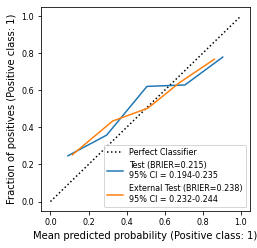

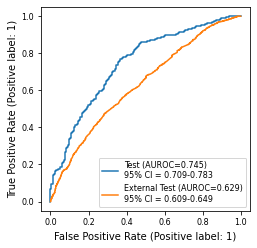

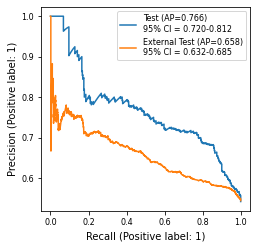

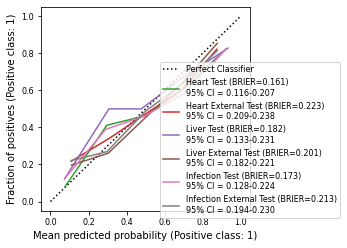

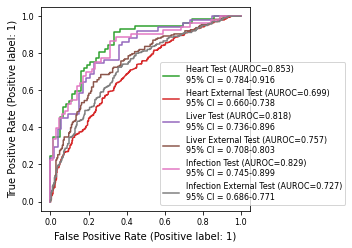

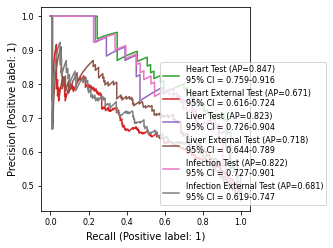

In [133]:
from models.static_models import CURVE_MAP

CURVE_PARAMS = {
    "calibration_curve": {
        "labels": ("prob_pred", "prob_true"),
        "limits": None,
        "metric": "brier",
    },
    "roc_curve": {"labels": ("fpr", "tpr"), "limits": (0, 1), "metric": "auroc"},
    "pr_curve": {"labels": ("recall", "precision"), "limits": None, "metric": "ap"},
    "det_curve": {"labels": ("fpr", "fnr"), "limits": None, "metric": "accuracy"},
}

import os
os.makedirs('./posthoc', exist_ok=True)

curve_names = args.curve_names
curve_fns = [CURVE_MAP[metric] for metric in curve_names]
curve_params = [CURVE_PARAMS[metric] for metric in curve_names]

plt_labels = ['Test', "External Test"]
runs = ['a07635aa0e50492d811d0ac7d9e807ac', '548afa05e3ee42208c20a2557dc1800a']
runs = ['125c0fb5c21f4533a45a9258822de83e', 'ce12b0e992014d30a3d0ee1d44610dc5']

subgroups = ["",]
subgroup_labels = [""]
colors = ['tab:blue', 'tab:orange']
plot_metrics(curve_names, curve_fns, curve_params, runs, subgroups, subgroup_labels, plt_labels, colors)

subgroups = ["_heart", "_liver", "_infection"]
subgroup_labels = ["Heart", "Liver", "Infection"]
colors = ['tab:green', 'tab:red', 'tab:purple', 'tab:brown','tab:pink', 'tab:gray']
plot_metrics(curve_names, curve_fns, curve_params, runs, subgroups, subgroup_labels, plt_labels, colors)

# Barplots for multiple evaluation cohort together

In [8]:
import os
os.makedirs('./posthoc', exist_ok=True)
metric_names = args.metric_names

def subgroup_forest(metric_names, plt_labels, runs, subgroups, subgroup_labels, subgroup_categories, tag=''):

    for metric_name in metric_names:

        grouped_metric_vals = []
        errors_low = []
        errors_high = []
            
        for i in range(len(runs)):
            run = client.get_run(runs[i])
            
            modeln = run.data.tags['modeln']

            metrics = run.data.metrics

            metric_values = []
            metric_values_low = []
            metric_values_high = []
                
            for j in range(len(subgroups)):
                
                prefix = f"{modeln}_test{subgroups[j]}"
                
                metric_values.append(metrics[prefix+'__'+metric_name])
                metric_values_low.append(metrics[prefix+'__'+metric_name+'_CI_low'])
                metric_values_high.append(metrics[prefix+'__'+metric_name+'_CI_high'])
            
            error_low = np.array(metric_values) - np.array(metric_values_low)
            error_high = np.array(metric_values_high) - np.array(metric_values)
            
            grouped_metric_vals.append(metric_values)
            errors_low.append(error_low)
            errors_high.append(error_high)
        
        width = 0.25
        multiplier = 0
        
        fig, ax = plt.subplots()

        x = []
        grouping_x = []
        groupings = []
        prev_grouping = None
        current_grouping = None
        index = len(subgroup_labels) + len(np.unique(subgroup_categories)) - 1
        for i in range(len(subgroup_labels)):
            current_grouping = subgroup_categories[i]
            if current_grouping != prev_grouping:
                grouping_x.append(index)
                groupings.append(current_grouping)
                index -= 1
                prev_grouping = current_grouping

            x.append(index)
            index -= 1
        x = np.array(x)
        
        for i in range(len(plt_labels)):
            offset = width * multiplier

            # ax.bar(x + offset, grouped_metric_vals[i], width, label=plt_labels[i], yerr=[errors_low[i], errors_high[i]])
            # plt.errorbar(x + offset, grouped_metric_vals[i], yerr=[errors_low[i], errors_high[i]], marker="d", capsize=5, elinewidth=2,label=plt_labels[i])
            plt.errorbar(grouped_metric_vals[i], x + offset, xerr=[errors_low[i], errors_high[i]], marker="D", capsize=3, elinewidth=1,label=plt_labels[i], linestyle='none')

            multiplier += 1
        
        # ax.plot([0., x[-1]], [grouped_metric_vals[0][0], grouped_metric_vals[0][0]], "k--")
        # ax.plot([0., x[-1]], [grouped_metric_vals[1][0], grouped_metric_vals[1][0]], "k--")
        ax.plot([grouped_metric_vals[0][0], grouped_metric_vals[0][0]], [0., x[0]], "k--", linewidth=1)
        try:
            ax.plot([grouped_metric_vals[1][0], grouped_metric_vals[1][0]], [0., x[0]], "k--", linewidth=1)
        except:
            pass
        ax.set_yticks(grouping_x, groupings, minor=False, fontweight='bold')
        ax.set_yticks(x + width, subgroup_labels, minor=True)
        ax.set_xlim([0,1])
        ax.tick_params(axis='y', which='major', length=0)

        # plt.yticks(ha='left')

        # ax.set_title(name)
        ax.set_xlabel(metric_name.upper())

        name = f"test_{metric_name}_subgroup_{tag}" 
        print(name)
        ax.legend()
        fig = plt.gcf()
        fig.set_size_inches(3, 10)
        plt.savefig(f'./posthoc/{name}forestplot.svg', format='svg',  bbox_inches="tight")


## UCLA -> UCLA + CEDARS

test_ap_subgroup_
test_brier_subgroup_
test_accuracy_subgroup_
test_precision_subgroup_
test_recall_subgroup_
test_auroc_subgroup_
test_TP_subgroup_
test_TN_subgroup_
test_FP_subgroup_
test_FN_subgroup_


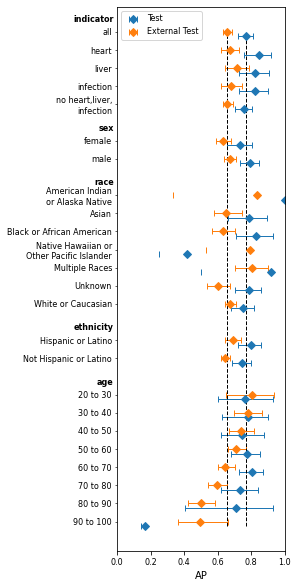

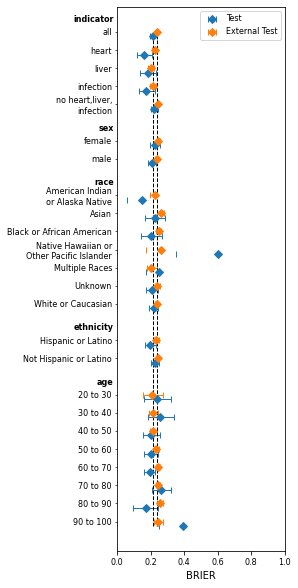

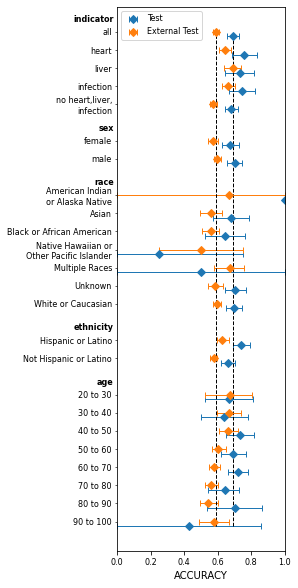

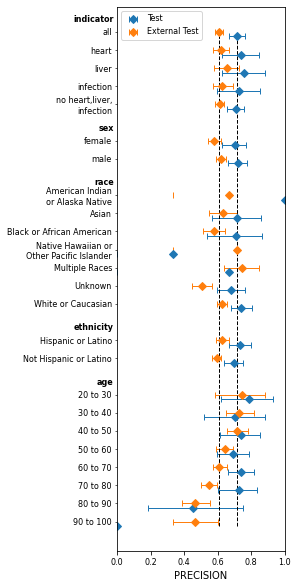

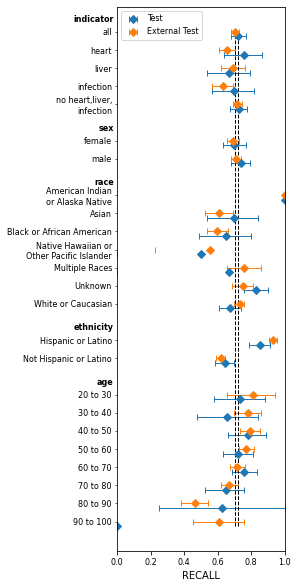

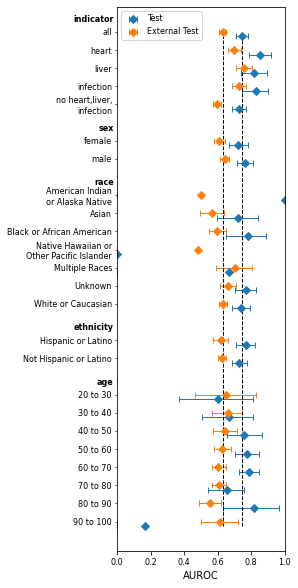

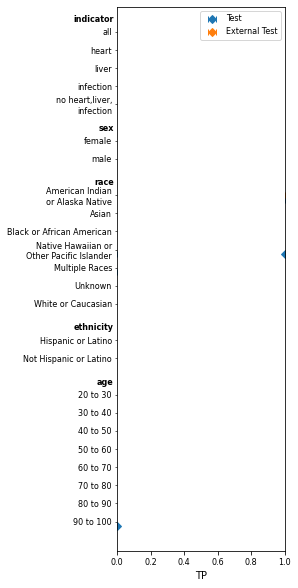

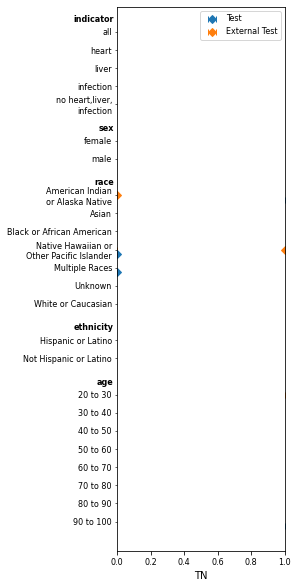

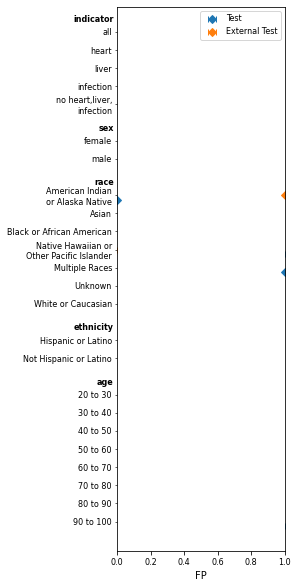

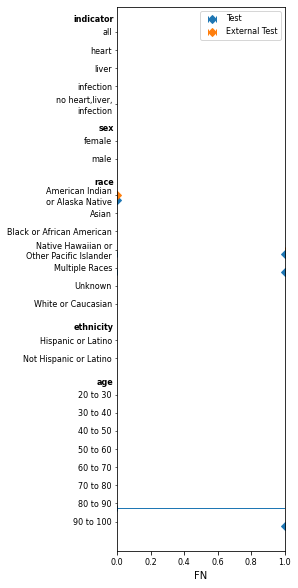

In [9]:
plt_labels = ['Test', "External Test"]
runs = ['125c0fb5c21f4533a45a9258822de83e', 'ce12b0e992014d30a3d0ee1d44610dc5']
subgroups = ["", "_heart", "_liver", "_infection",'_no_heart_liver_infection',
            '_female','_male', 
            '_American Indian or Alaska Native','_Asian','_Black or African American','_Native Hawaiian or Other Pacific Islander','_Multiple Races','_Unknown','_White or Caucasian',
            '_Hispanic or Latino','_Not Hispanic or Latino',
            '_age_20_to_30', '_age_30_to_40', '_age_40_to_50', '_age_50_to_60', '_age_60_to_70', '_age_70_to_80','_age_80_to_90','_age_90_to_100']
subgroup_labels = ["all", "heart", "liver", "infection","no heart,liver,\ninfection",
                   'female','male', 
            'American Indian\nor Alaska Native','Asian','Black or African American','Native Hawaiian or\nOther Pacific Islander','Multiple Races','Unknown','White or Caucasian',
            'Hispanic or Latino','Not Hispanic or Latino',
            '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100']
subgroup_categories = ["indicator", "indicator", "indicator", "indicator","indicator",
                   'sex','sex', 
            'race','race','race','race','race','race','race',
            'ethnicity','ethnicity',
            'age','age','age','age','age','age','age','age']
subgroup_forest(metric_names, plt_labels, runs, subgroups, subgroup_labels, subgroup_categories)

## Cedars -> UCLA + CEDARS

test_ap_subgroup_
test_brier_subgroup_
test_accuracy_subgroup_
test_precision_subgroup_
test_recall_subgroup_
test_auroc_subgroup_
test_TP_subgroup_
test_TN_subgroup_
test_FP_subgroup_
test_FN_subgroup_


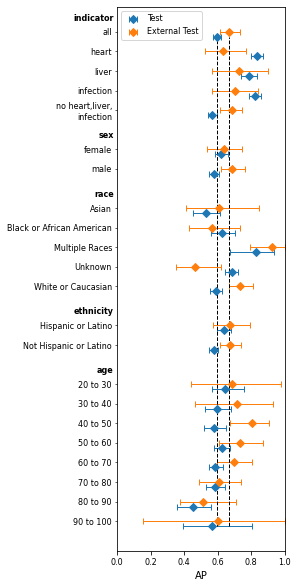

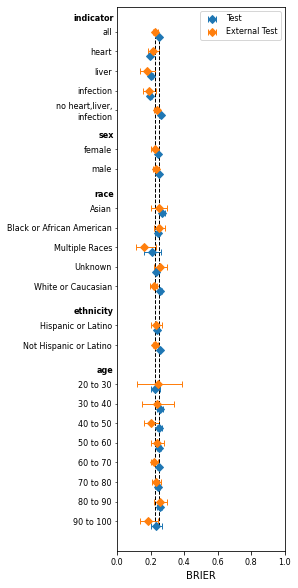

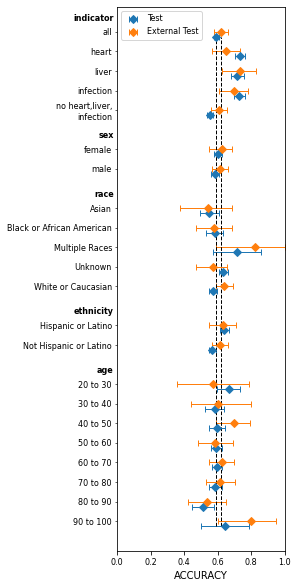

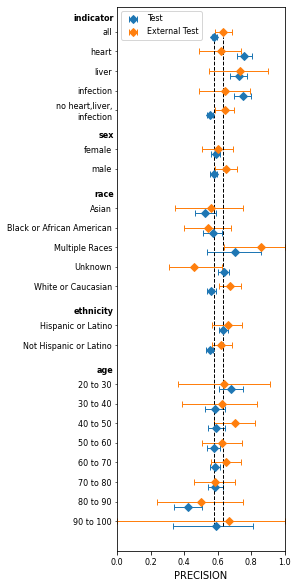

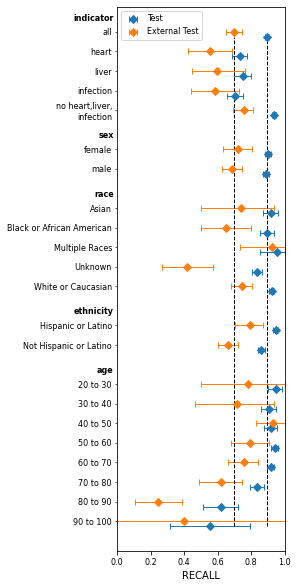

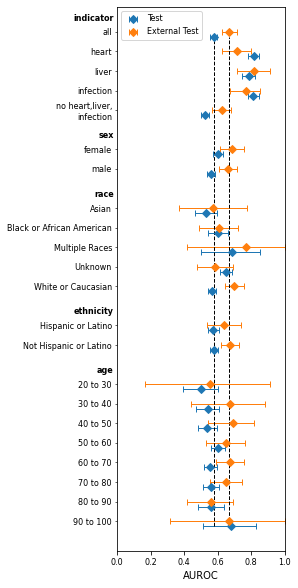

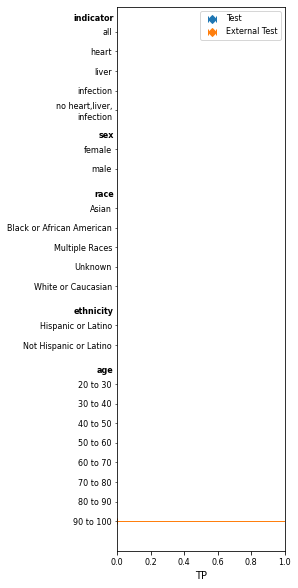

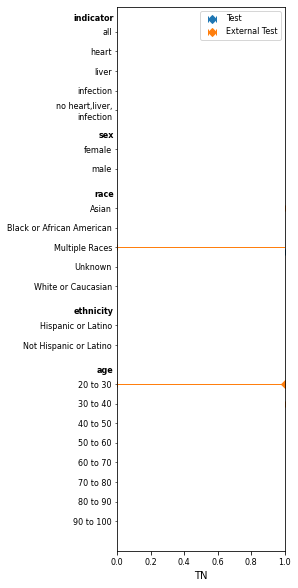

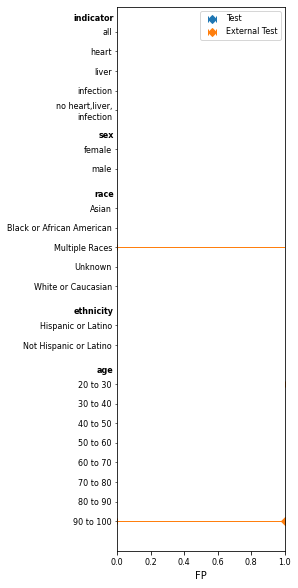

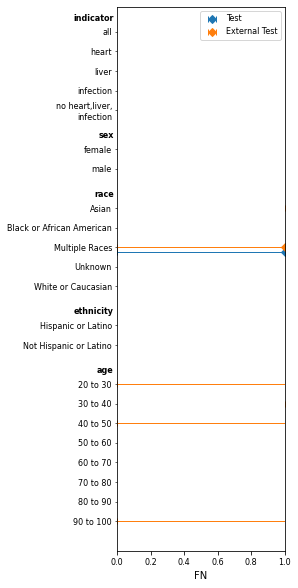

In [136]:
plt_labels = ['Test', "External Test"]
runs = ['a07635aa0e50492d811d0ac7d9e807ac', '548afa05e3ee42208c20a2557dc1800a']
subgroups = ["", "_heart", "_liver", "_infection",'_no_heart_liver_infection',
            '_female','_male', 
            '_Asian','_Black or African American','_Multiple Races','_Unknown','_White or Caucasian',
            '_Hispanic or Latino','_Not Hispanic or Latino',
            '_age_20_to_30', '_age_30_to_40', '_age_40_to_50', '_age_50_to_60', '_age_60_to_70', '_age_70_to_80','_age_80_to_90','_age_90_to_100']
subgroup_labels = ["all", "heart", "liver", "infection","no heart,liver,\ninfection",
                   'female','male', 
            'Asian','Black or African American','Multiple Races','Unknown','White or Caucasian',
            'Hispanic or Latino','Not Hispanic or Latino',
            '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100']
subgroup_categories = ["indicator", "indicator", "indicator", "indicator","indicator",
                   'sex','sex', 
            'race','race','race','race','race',
            'ethnicity','ethnicity',
            'age','age','age','age','age','age','age','age']
subgroup_forest(metric_names, plt_labels, runs, subgroups, subgroup_labels, subgroup_categories)

## BOTH


test_ap_subgroup_
test_brier_subgroup_
test_accuracy_subgroup_
test_precision_subgroup_
test_recall_subgroup_
test_auroc_subgroup_
test_TP_subgroup_
test_TN_subgroup_
test_FP_subgroup_
test_FN_subgroup_


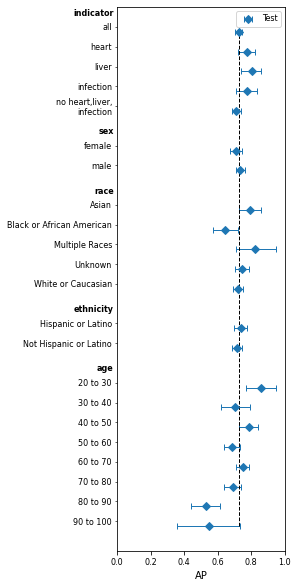

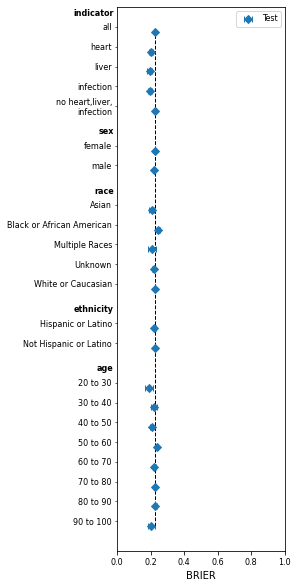

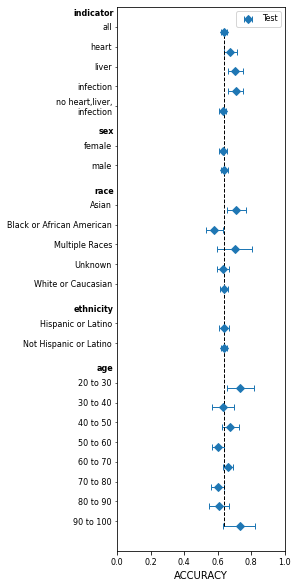

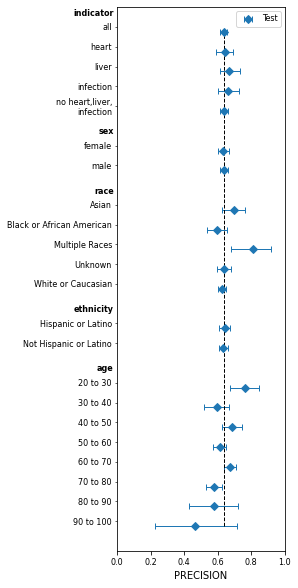

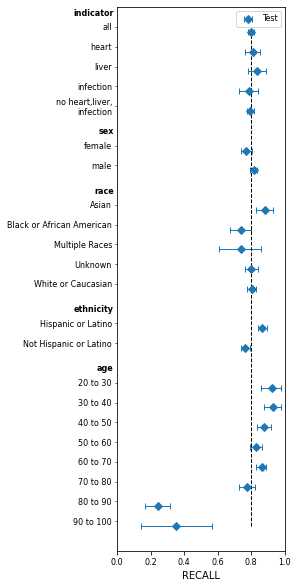

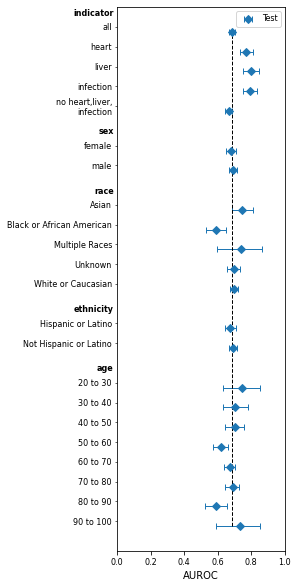

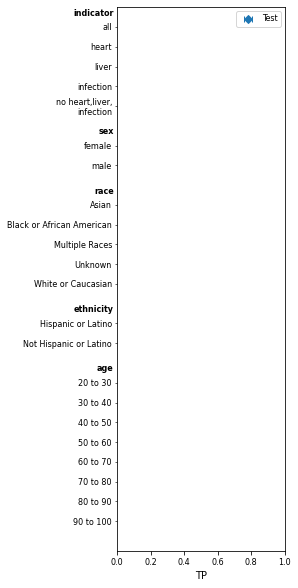

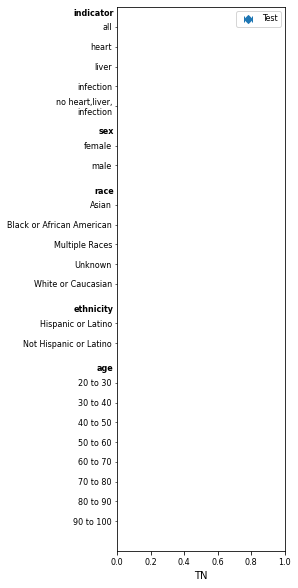

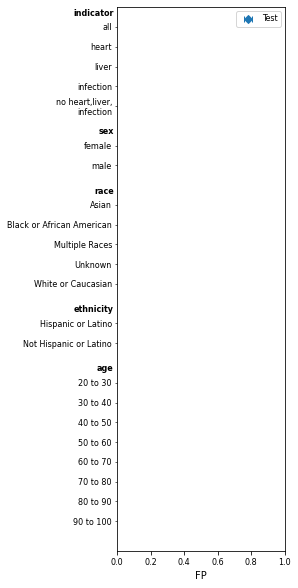

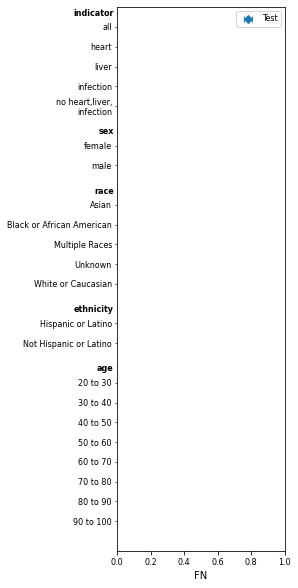

In [137]:
plt_labels = ['Test']
runs = ['7bbdb269ea9041f799fa9de7e7d34b45']
subgroups = ["", "_heart", "_liver", "_infection",'_no_heart_liver_infection',
            '_female','_male', 
            '_Asian','_Black or African American','_Multiple Races','_Unknown','_White or Caucasian',
            '_Hispanic or Latino','_Not Hispanic or Latino',
            '_age_20_to_30', '_age_30_to_40', '_age_40_to_50', '_age_50_to_60', '_age_60_to_70', '_age_70_to_80','_age_80_to_90','_age_90_to_100']
subgroup_labels = ["all", "heart", "liver", "infection","no heart,liver,\ninfection",
                   'female','male', 
            'Asian','Black or African American','Multiple Races','Unknown','White or Caucasian',
            'Hispanic or Latino','Not Hispanic or Latino',
            '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100']
subgroup_categories = ["indicator", "indicator", "indicator", "indicator","indicator",
                   'sex','sex', 
            'race','race','race','race','race',
            'ethnicity','ethnicity',
            'age','age','age','age','age','age','age','age']
subgroup_forest(metric_names, plt_labels, runs, subgroups, subgroup_labels, subgroup_categories)

## Limit 

test_ap_subgroup_
test_brier_subgroup_
test_accuracy_subgroup_
test_precision_subgroup_
test_recall_subgroup_
test_auroc_subgroup_
test_TP_subgroup_
test_TN_subgroup_
test_FP_subgroup_
test_FN_subgroup_


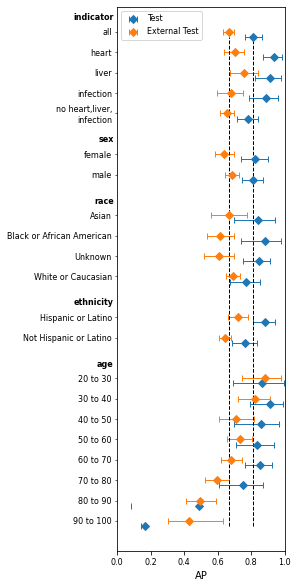

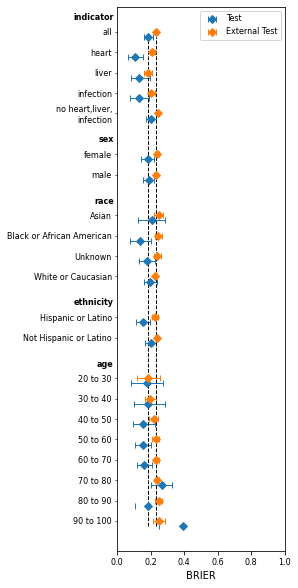

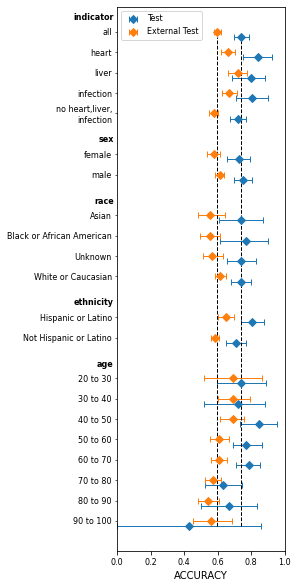

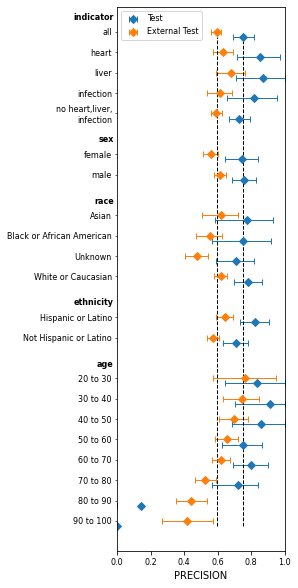

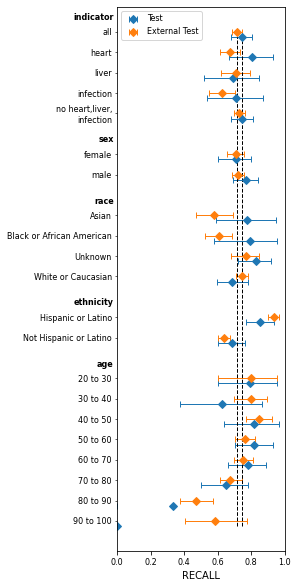

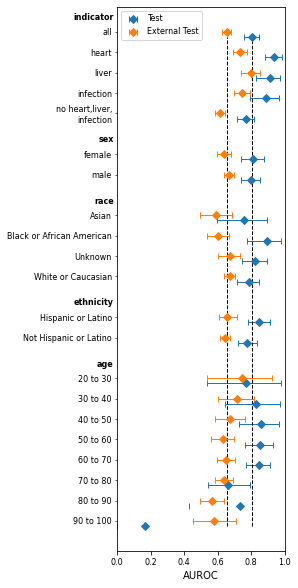

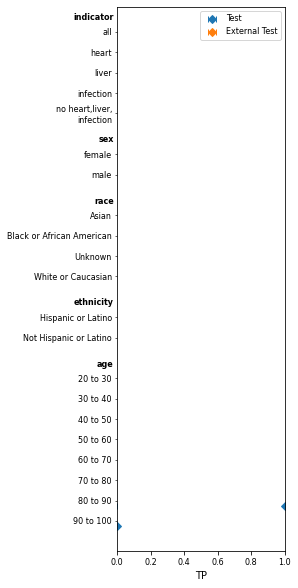

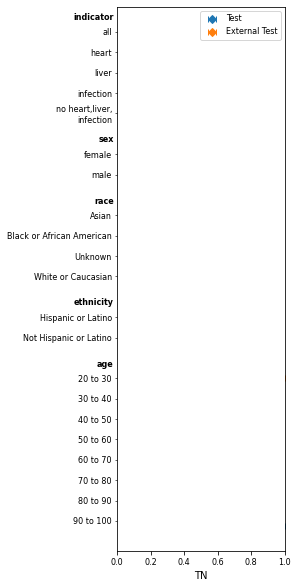

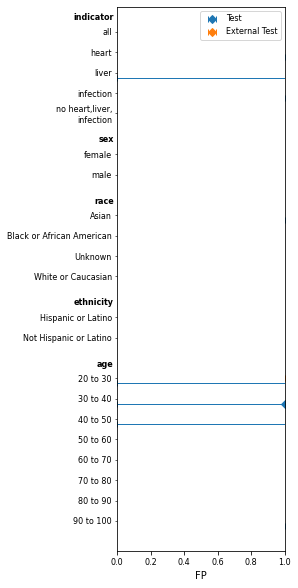

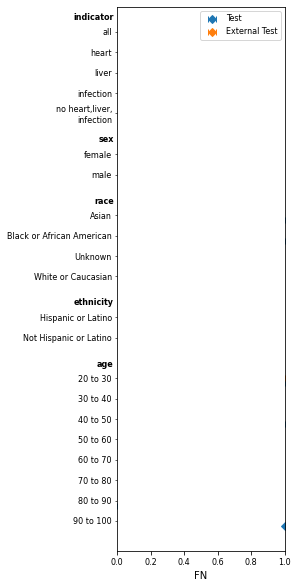

In [138]:
plt_labels = ['Test', "External Test"]
runs = ['52d929585bd84345a5007ec99e1f3185', '5801be55809c4e3e91478d26ee0ee614']
subgroups = ["", "_heart", "_liver", "_infection",'_no_heart_liver_infection',
            '_female','_male', 
            '_Asian','_Black or African American','_Unknown','_White or Caucasian',
            '_Hispanic or Latino','_Not Hispanic or Latino',
            '_age_20_to_30', '_age_30_to_40', '_age_40_to_50', '_age_50_to_60', '_age_60_to_70', '_age_70_to_80','_age_80_to_90','_age_90_to_100']
subgroup_labels = ["all", "heart", "liver", "infection","no heart,liver,\ninfection",
                   'female','male', 
            'Asian','Black or African American','Unknown','White or Caucasian',
            'Hispanic or Latino','Not Hispanic or Latino',
            '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100']
subgroup_categories = ["indicator", "indicator", "indicator", "indicator","indicator",
                   'sex','sex', 
            'race','race','race','race',
            'ethnicity','ethnicity',
            'age','age','age','age','age','age','age','age']
subgroup_forest(metric_names, plt_labels, runs, subgroups, subgroup_labels, subgroup_categories)

test_ap_subgroup_
test_brier_subgroup_
test_accuracy_subgroup_
test_precision_subgroup_
test_recall_subgroup_
test_auroc_subgroup_
test_TP_subgroup_
test_TN_subgroup_
test_FP_subgroup_
test_FN_subgroup_


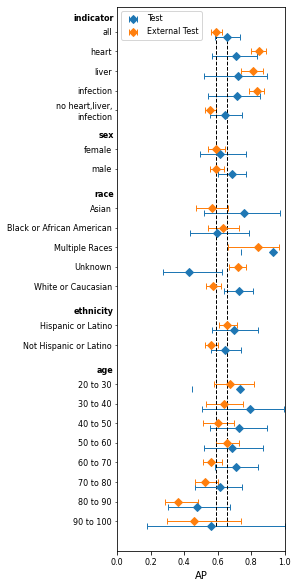

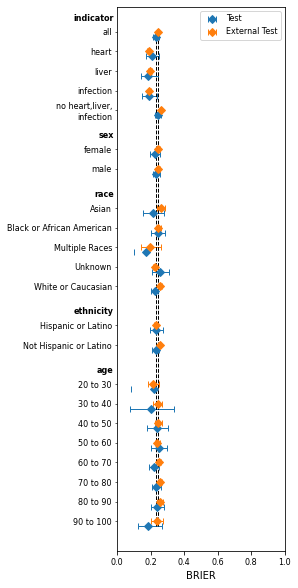

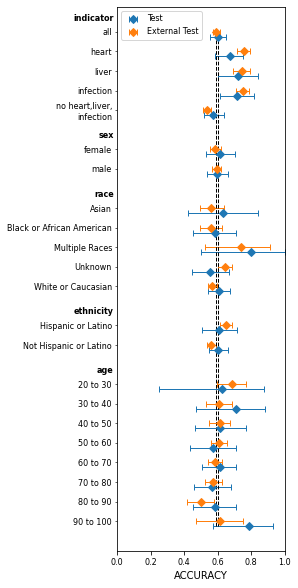

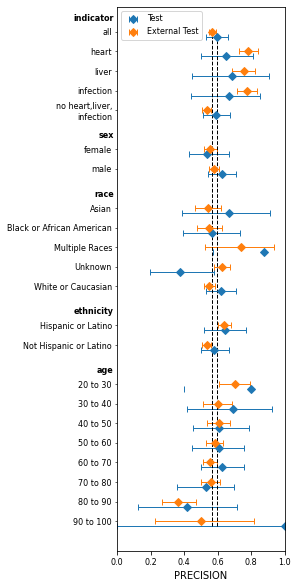

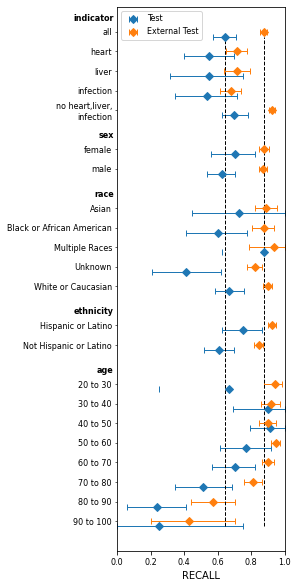

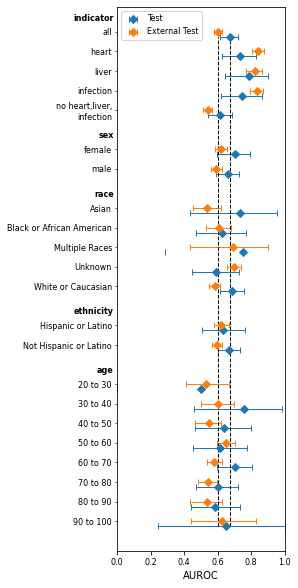

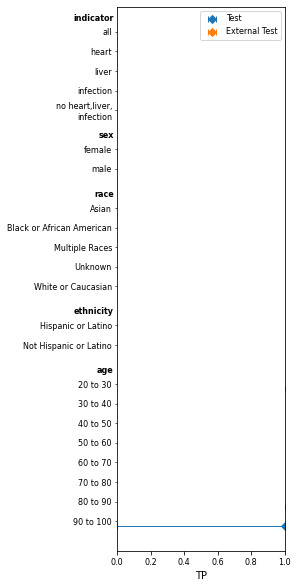

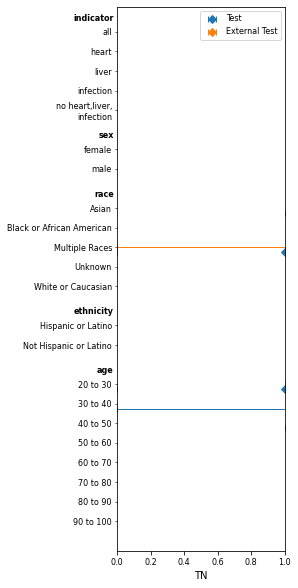

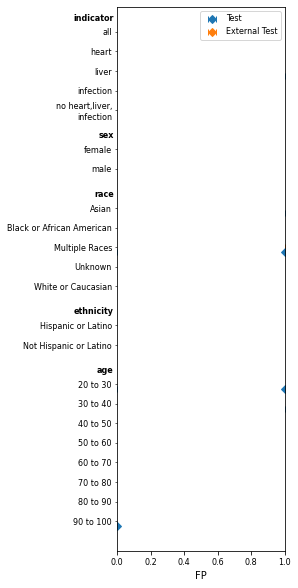

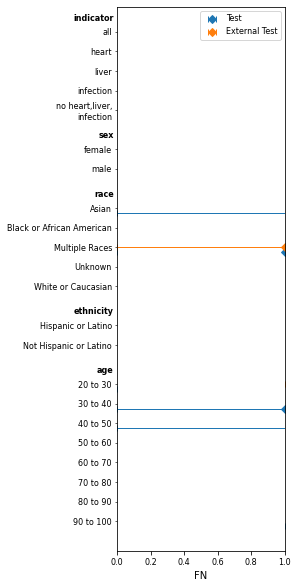

In [139]:
plt_labels = ['Test', "External Test"]
runs = ['cf50989ed9e24cf3aefd4b6232c40ff5', 'b985f4b14d9e42da85dc296ce9e64118']
subgroups = ["", "_heart", "_liver", "_infection",'_no_heart_liver_infection',
            '_female','_male', 
            '_Asian','_Black or African American','_Multiple Races','_Unknown','_White or Caucasian',
            '_Hispanic or Latino','_Not Hispanic or Latino',
            '_age_20_to_30', '_age_30_to_40', '_age_40_to_50', '_age_50_to_60', '_age_60_to_70', '_age_70_to_80','_age_80_to_90','_age_90_to_100']
subgroup_labels = ["all", "heart", "liver", "infection","no heart,liver,\ninfection",
                   'female','male', 
            'Asian','Black or African American','Multiple Races','Unknown','White or Caucasian',
            'Hispanic or Latino','Not Hispanic or Latino',
            '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100']
subgroup_categories = ["indicator", "indicator", "indicator", "indicator","indicator",
                   'sex','sex', 
            'race','race','race','race','race',
            'ethnicity','ethnicity',
            'age','age','age','age','age','age','age','age']
subgroup_forest(metric_names, plt_labels, runs, subgroups, subgroup_labels, subgroup_categories)

test_ap_subgroup_
test_brier_subgroup_
test_accuracy_subgroup_
test_precision_subgroup_
test_recall_subgroup_
test_auroc_subgroup_
test_TP_subgroup_
test_TN_subgroup_
test_FP_subgroup_
test_FN_subgroup_


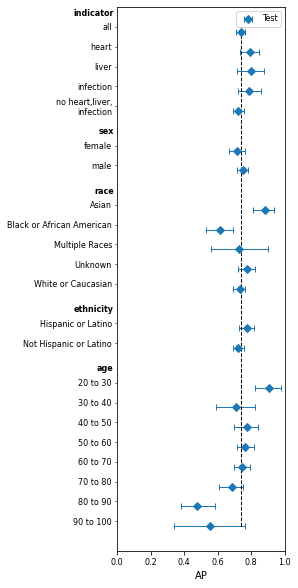

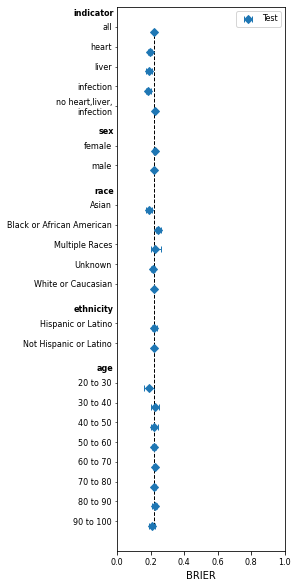

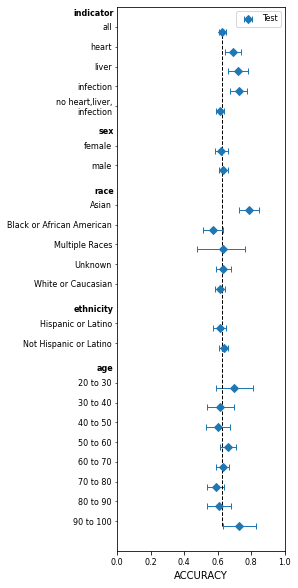

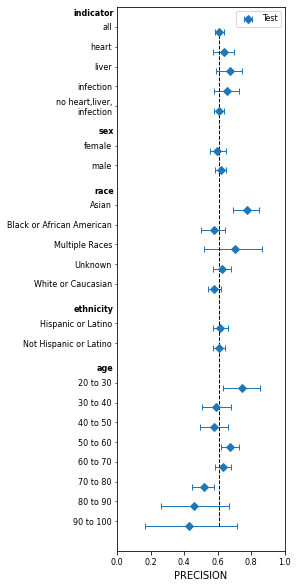

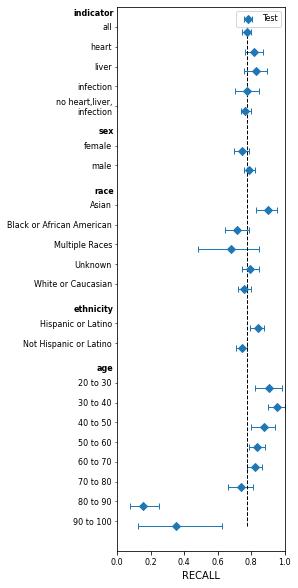

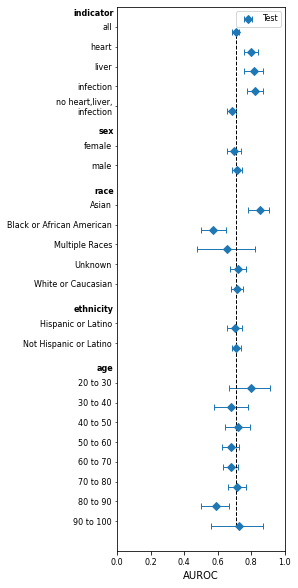

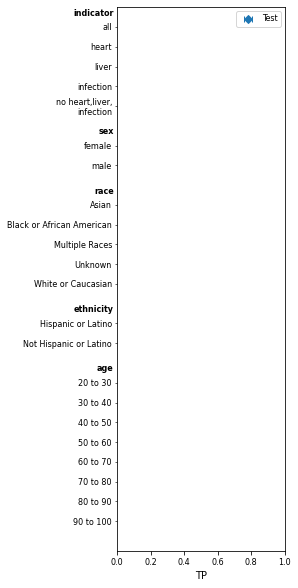

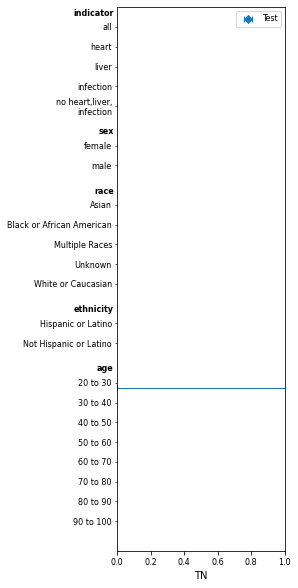

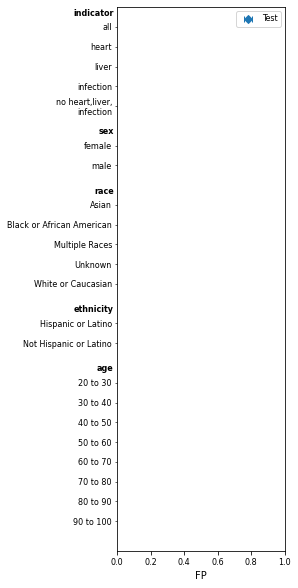

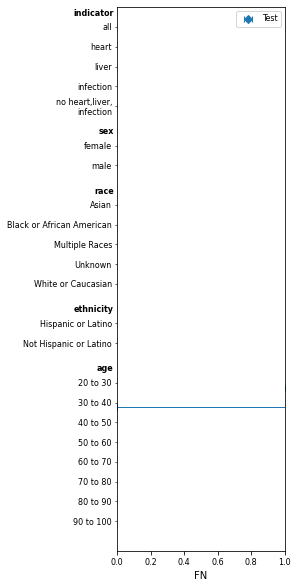

In [140]:
plt_labels = ['Test']
runs = ['e7538934abdf4977af24b114fcac83d9']
subgroups = ["", "_heart", "_liver", "_infection",'_no_heart_liver_infection',
            '_female','_male', 
            '_Asian','_Black or African American','_Multiple Races','_Unknown','_White or Caucasian',
            '_Hispanic or Latino','_Not Hispanic or Latino',
            '_age_20_to_30', '_age_30_to_40', '_age_40_to_50', '_age_50_to_60', '_age_60_to_70', '_age_70_to_80','_age_80_to_90','_age_90_to_100']
subgroup_labels = ["all", "heart", "liver", "infection","no heart,liver,\ninfection",
                   'female','male', 
            'Asian','Black or African American','Multiple Races','Unknown','White or Caucasian',
            'Hispanic or Latino','Not Hispanic or Latino',
            '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100']
subgroup_categories = ["indicator", "indicator", "indicator", "indicator","indicator",
                   'sex','sex', 
            'race','race','race','race','race',
            'ethnicity','ethnicity',
            'age','age','age','age','age','age','age','age']
subgroup_forest(metric_names, plt_labels, runs, subgroups, subgroup_labels, subgroup_categories)

# Rolling window

## UCLA -> UCLA

In [12]:
def plot_rolling_window(metric_names, subgroups, subgroup_labels, runs, plt_labels, groups, colors=None):
    for metric_name in metric_names:
            
        for i in range(len(subgroups)):
            
            grouped_metric_vals = []
            errors_low = []
            errors_high = []

            for j in range(len(runs)):
                metric_values = []
                metric_values_low = []
                metric_values_high = []
            
                for k in range(len(runs[j])):

                    run = client.get_run(runs[j][k])
                
                    modeln = run.data.tags['modeln']
                    prefix = f"{modeln}_test{subgroups[i]}"

                    metrics = run.data.metrics
                    
                    metric_values.append(metrics[prefix+'__'+metric_name])
                    metric_values_low.append(metrics[prefix+'__'+metric_name+'_CI_low'])
                    metric_values_high.append(metrics[prefix+'__'+metric_name+'_CI_high'])
                
                error_low = np.array(metric_values) - np.array(metric_values_low)
                error_high = np.array(metric_values_high) - np.array(metric_values)
                
                grouped_metric_vals.append(metric_values)
                errors_low.append(error_low)
                errors_high.append(error_high)

                name = f"test_{metric_name}_{subgroup_labels[i]}_{groups[j]}"
                
                fig, ax = plt.subplots()
                x = np.arange(len(plt_labels))

                plt.errorbar(x, metric_values, yerr=[error_low, error_high], marker="d",linestyle='--',capsize=5, elinewidth=2,)
                ax.set_xticks(x, plt_labels)
                ax.set_ylim([0,1])
                # ax.set_title(name)
                ax.set_ylabel(metric_name.upper())
                ax.set_xlabel('Days before start date')
                print(name)
                fig = plt.gcf()
                fig.set_size_inches(5, 3)
                plt.show()
                
            fig, ax = plt.subplots()
            name = f"test_{metric_name}_{subgroup_labels[i]}"

            width = 0.1
            multiplier = 0
            x = np.arange(len(plt_labels))

            for j in range(len(groups)):
                offset = width * multiplier

                # ax.bar(x + offset, grouped_metric_vals[i], width, label=plt_labels[i], yerr=[errors_low[i], errors_high[i]])

                if colors is not None:
                    plt.errorbar(x + offset, grouped_metric_vals[j], yerr=[errors_low[j], errors_high[j]], marker="d",linestyle='--', capsize=5, elinewidth=2,label=groups[j], color=colors[j])
                else:
                    plt.errorbar(x + offset, grouped_metric_vals[j], yerr=[errors_low[j], errors_high[j]], marker="d",linestyle='--', capsize=5, elinewidth=2,label=groups[j])
                
                multiplier += 1
            
            ax.set_xticks(x + width, plt_labels)
            # ax.set_title(name)
            ax.set_ylabel(metric_name.upper())
            ax.set_xlabel('Days before start date')
            ax.set_ylim([0,1])
            print(name)
            ax.legend()
            fig = plt.gcf()
            fig.set_size_inches(3, 3)
            plt.savefig(f'./posthoc/{name}_rolling.svg', format='svg',  bbox_inches="tight")

In [ ]:
metric_names = args.metric_names
metric_names = ['auroc']


groups = ['all', '0-7 days', '8-14 days', '15+']

plt_labels = ['6', "5", '4', "3", '2', "1", '0']
runs = [['c1e1215a95d140eda058a5bacc17a8e7',
        '73ade10083c443b6978c3d2ce5d4a766',
        '0d73855b2f8b40babc774cdc019ac3f5',
        '5bbd13f3ad3343f9800042cc4d271d74',
        'b2f35a3c973a4aee9b422edd31642c08',
        'ee2eeff4537c49ffb6a455b14aeec715',
        'f899fd8ea23f44c38e89c19a937b4111'],
        ['5e67a99b15534b9e8f50da8b7e5eddbd',
        'b48f1bf080c7429b9c819b7fc33b6a57',
        '4c990d3587f64321bf3167b9e9baf6b3',
        'c030454e79f04e618cb20debdbbc4fee',
        'b6321863269f40a69a57bd54022dff75',
        '4865ff3889bb471dabf5dcfbd1decd6a',
        '52d929585bd84345a5007ec99e1f3185',],
        ['0a1b37b147b54e719fb16bbca6ef56a2',
        '0116d54187414a03bb9bd8d7839db17b',
        '6c0953cf60d749b9aebcaf8d1e649478',
        'd498676e8a094294b2106bf3bd80f45f',
        '4b5e4715a56b4e8cbc65fb78b0d44241',
        'd19c5708af16404697bc525979a2ad0d',
        '56bc330c3743496d87f2450961dc91d8',],
        ['29eeb2b6e46d49ceb08de0d294a8bfe8',
        '288e7a8556934ee18f4ab7b42f33fbf6',
        '8bb152da9dcd457d833cadf7e96673a4',
        '80149a987aec45feac6c399e8603afea',
        'd81bc25a35c84feaad87bf130635f4c3',
        '577750b7357a45e2a51c01fced390d57',
        '2d6b2665f78942278b7add6f17f40906',]]


subgroups = ["", "_heart", "_liver", "_infection"]
subgroup_labels = ["all", "heart", "liver", "infection"]
plot_rolling_window(metric_names, subgroups, subgroup_labels, runs, plt_labels, groups)

test_auroc_all_all


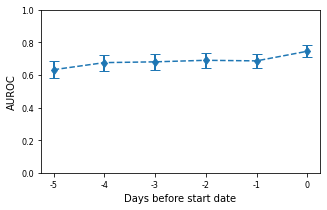

test_auroc_all_0-7 days


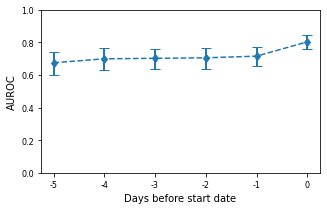

test_auroc_all
test_auroc_heart_all


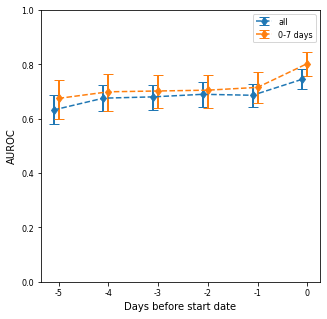

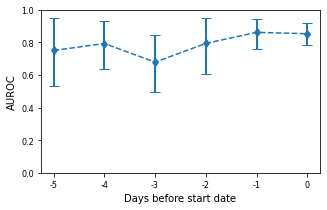

test_auroc_heart_0-7 days


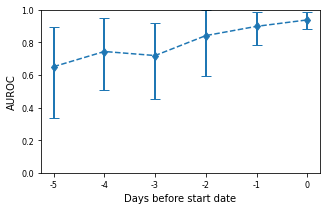

test_auroc_heart
test_auroc_liver_all


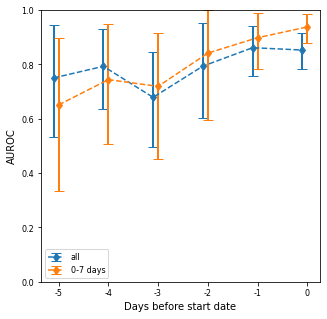

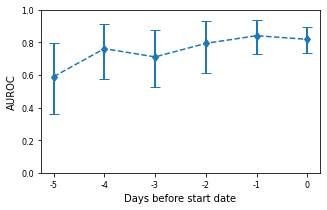

test_auroc_liver_0-7 days


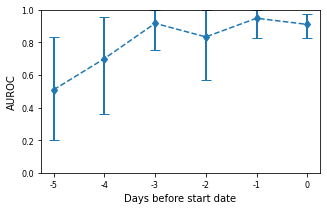

test_auroc_liver
test_auroc_infection_all


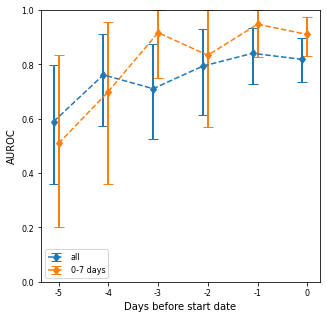

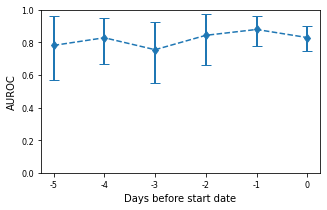

test_auroc_infection_0-7 days


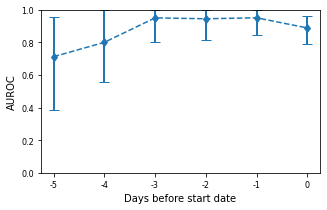

test_auroc_infection


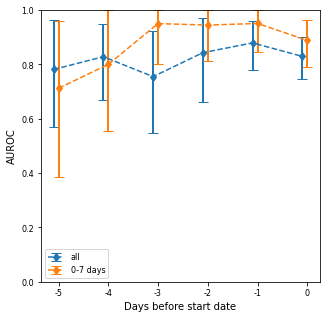

In [11]:
metric_names = args.metric_names
metric_names = ['auroc']


groups = ['all', '0-7 days', '8-14 days', '15+']
groups = ['all', '0-7 days']
plt_labels = [ "-5", '-4', "-3", '-2', "-1", '0']
runs = [[#'c1e1215a95d140eda058a5bacc17a8e7',
        '73ade10083c443b6978c3d2ce5d4a766',
        '0d73855b2f8b40babc774cdc019ac3f5',
        '5bbd13f3ad3343f9800042cc4d271d74',
        'b2f35a3c973a4aee9b422edd31642c08',
        'ee2eeff4537c49ffb6a455b14aeec715',
        'f899fd8ea23f44c38e89c19a937b4111'],
        [#'5e67a99b15534b9e8f50da8b7e5eddbd',
        'b48f1bf080c7429b9c819b7fc33b6a57',
        '4c990d3587f64321bf3167b9e9baf6b3',
        'c030454e79f04e618cb20debdbbc4fee',
        'b6321863269f40a69a57bd54022dff75',
        '4865ff3889bb471dabf5dcfbd1decd6a',
        '52d929585bd84345a5007ec99e1f3185',],
        # ['0a1b37b147b54e719fb16bbca6ef56a2',
        # '0116d54187414a03bb9bd8d7839db17b',
        # '6c0953cf60d749b9aebcaf8d1e649478',
        # 'd498676e8a094294b2106bf3bd80f45f',
        # '4b5e4715a56b4e8cbc65fb78b0d44241',
        # 'd19c5708af16404697bc525979a2ad0d',
        # '56bc330c3743496d87f2450961dc91d8',],
        # ['29eeb2b6e46d49ceb08de0d294a8bfe8',
        # '288e7a8556934ee18f4ab7b42f33fbf6',
        # '8bb152da9dcd457d833cadf7e96673a4',
        # '80149a987aec45feac6c399e8603afea',
        # 'd81bc25a35c84feaad87bf130635f4c3',
        # '577750b7357a45e2a51c01fced390d57',
        # '2d6b2665f78942278b7add6f17f40906',]
        ]


subgroups = ["", "_heart", "_liver", "_infection"]
subgroup_labels = ["all", "heart", "liver", "infection"]
plot_rolling_window(metric_names, subgroups, subgroup_labels, runs, plt_labels, groups)

## UCLA -> CEDARS

test_auroc_all_all


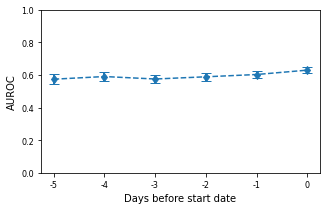

test_auroc_all_0-7 days


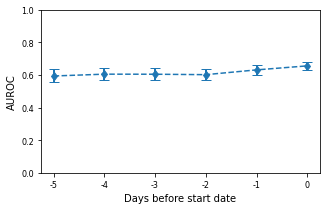

test_auroc_all
test_auroc_heart_all


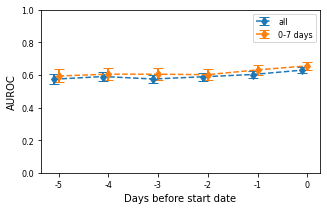

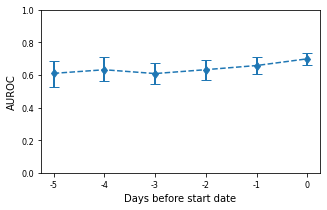

test_auroc_heart_0-7 days


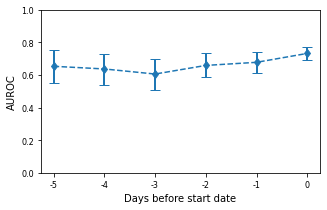

test_auroc_heart
test_auroc_liver_all


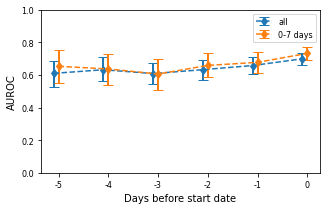

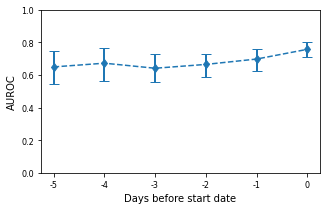

test_auroc_liver_0-7 days


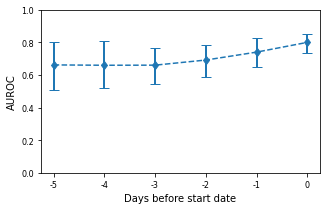

test_auroc_liver
test_auroc_infection_all


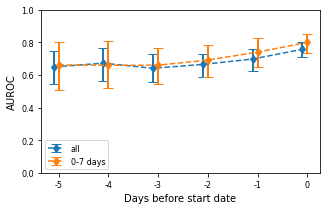

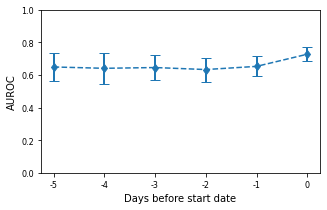

test_auroc_infection_0-7 days


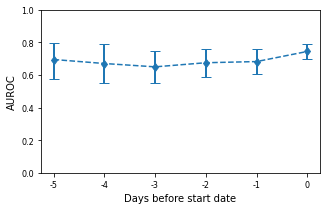

test_auroc_infection


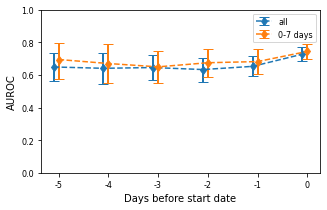

In [4]:
metric_names = args.metric_names
metric_names = ['auroc']


groups = ['all', '0-7 days', '8-14 days', '15+']
groups = ['all', '0-7 days']

plt_labels = ["-5", '-4', "-3", '-2', "-1", '0']
runs = [[#'bdc911c822c4415bb54ce89a313d1a7e',
        '449f163e30484aebb90007d924825f39',
        '50a9e848d8fd4aa9a5570fd6907042b8',
        'c050ec741e624dbdac6ca292f6e08f77',
        '9515d0823f0b425f8e97881de5478f41',
        '54086b89dda9449e8b7d425fa6d13c28',
        '796fe8106bd24d69a7c282a068916742'],
        [#'e753c68e4ee74712a2e5a15017785c99',
        'df136a09085c47caa61cc5843cfedcab',
        '035f987b9e114c92a5c8bc08a96cc6f2',
        '4a2a83cddb3b4826946fdbde73fa4790',
        '13b8a6ef83d946dd941db5835277f16e',
        'e96fdb411f444c7fb1eaf536aa3ec9ff',
        '5801be55809c4e3e91478d26ee0ee614',],
        # [#'59257af9f74d4717a1594ba2da17f35c',
        # '2efd1ec507f44e3d83cbcacef03e7147',
        # '0fcc2380c56745e8a60ab9b649bac676',
        # 'f49df2ce4f4d4081aa614dd63f037e82',
        # '53ca636a65134752bf9d955db639b609',
        # '6c8218631d1940a280d5df494406304a',
        # '5e3bca6c35e342b0b1945f216a90af90',],
        # [#'ca0a4bb8f7724d82a566e161e1542c5b',
        # '2c1c3138cdc0494b8e49b95764e63575',
        # '26e491b66f00425d85a75e88818265b5',
        # '205399c3b4a64ebdba056e56cf292a05',
        # 'd6c385dd87984da28842ff7acd5ffdc7',
        # 'acd3199f5fdc44d384af80cc6f7df62c',
        # '70c939cd7f6a4a96839fb18119bc3a2e',]
        ]


subgroups = ["", "_heart", "_liver", "_infection"]
subgroup_labels = ["all", "heart", "liver", "infection"]
plot_rolling_window(metric_names, subgroups, subgroup_labels, runs, plt_labels, groups)

## UCLA -> UCLA, UCLA -> CEDARS

test_auroc_all_Test all


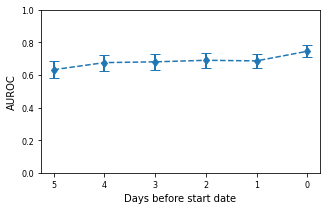

test_auroc_all_Test 0-7 days


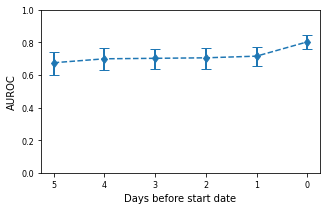

test_auroc_all_External test all


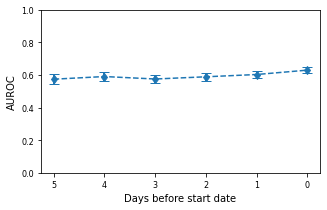

test_auroc_all_External test 0-7 days


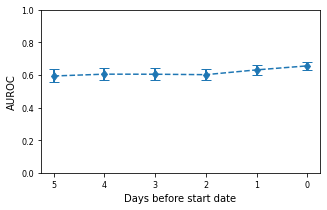

test_auroc_all
test_auroc_heart_Test all


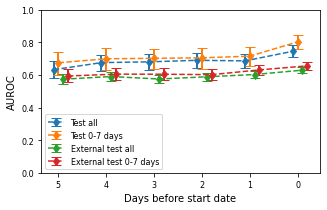

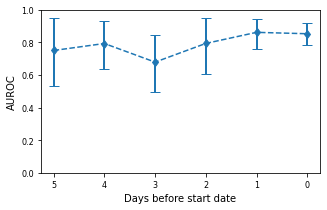

test_auroc_heart_Test 0-7 days


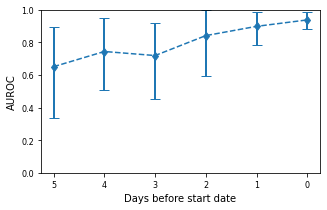

test_auroc_heart_External test all


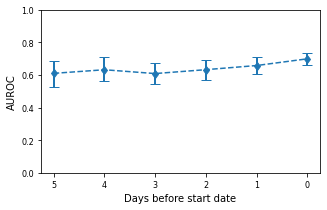

test_auroc_heart_External test 0-7 days


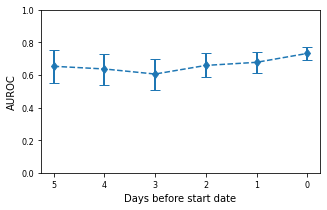

test_auroc_heart
test_auroc_liver_Test all


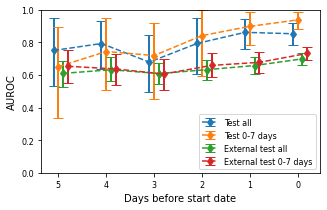

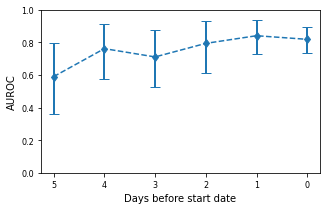

test_auroc_liver_Test 0-7 days


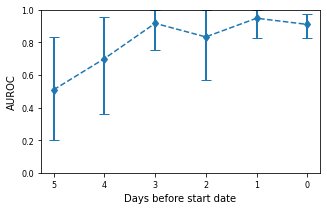

test_auroc_liver_External test all


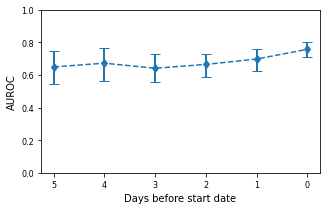

test_auroc_liver_External test 0-7 days


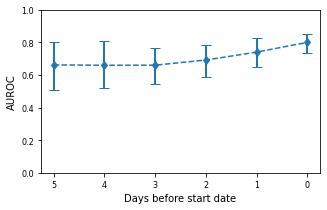

test_auroc_liver
test_auroc_infection_Test all


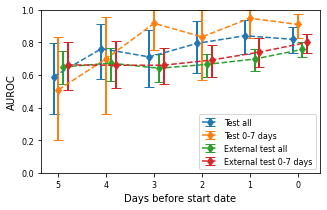

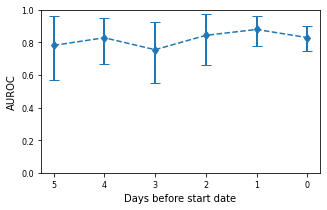

test_auroc_infection_Test 0-7 days


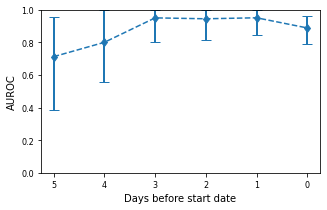

test_auroc_infection_External test all


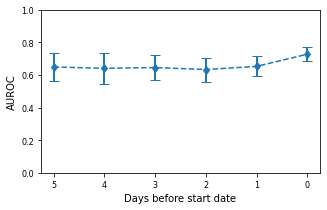

test_auroc_infection_External test 0-7 days


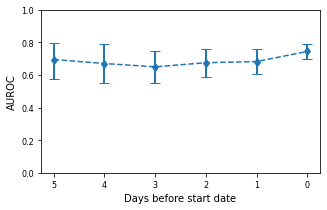

test_auroc_infection


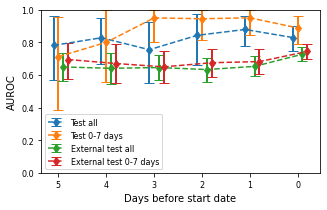

In [5]:
metric_names = args.metric_names
metric_names = ['auroc']


groups = ['Test all', 'Test 0-7 days', 'External test all', 'External test 0-7 days']


metric_names = args.metric_names
metric_names = ['auroc']


plt_labels = [ "5", '4', "3", '2', "1", '0']
runs = [[#'c1e1215a95d140eda058a5bacc17a8e7',
        '73ade10083c443b6978c3d2ce5d4a766',
        '0d73855b2f8b40babc774cdc019ac3f5',
        '5bbd13f3ad3343f9800042cc4d271d74',
        'b2f35a3c973a4aee9b422edd31642c08',
        'ee2eeff4537c49ffb6a455b14aeec715',
        'f899fd8ea23f44c38e89c19a937b4111'],
        [#'5e67a99b15534b9e8f50da8b7e5eddbd',
        'b48f1bf080c7429b9c819b7fc33b6a57',
        '4c990d3587f64321bf3167b9e9baf6b3',
        'c030454e79f04e618cb20debdbbc4fee',
        'b6321863269f40a69a57bd54022dff75',
        '4865ff3889bb471dabf5dcfbd1decd6a',
        '52d929585bd84345a5007ec99e1f3185',],
        [#'bdc911c822c4415bb54ce89a313d1a7e',
        '449f163e30484aebb90007d924825f39',
        '50a9e848d8fd4aa9a5570fd6907042b8',
        'c050ec741e624dbdac6ca292f6e08f77',
        '9515d0823f0b425f8e97881de5478f41',
        '54086b89dda9449e8b7d425fa6d13c28',
        '796fe8106bd24d69a7c282a068916742'],
        [#'e753c68e4ee74712a2e5a15017785c99',
        'df136a09085c47caa61cc5843cfedcab',
        '035f987b9e114c92a5c8bc08a96cc6f2',
        '4a2a83cddb3b4826946fdbde73fa4790',
        '13b8a6ef83d946dd941db5835277f16e',
        'e96fdb411f444c7fb1eaf536aa3ec9ff',
        '5801be55809c4e3e91478d26ee0ee614',],
        # [#'59257af9f74d4717a1594ba2da17f35c',
        # '2efd1ec507f44e3d83cbcacef03e7147',
        # '0fcc2380c56745e8a60ab9b649bac676',
        # 'f49df2ce4f4d4081aa614dd63f037e82',
        # '53ca636a65134752bf9d955db639b609',
        # '6c8218631d1940a280d5df494406304a',
        # '5e3bca6c35e342b0b1945f216a90af90',],
        # [#'ca0a4bb8f7724d82a566e161e1542c5b',
        # '2c1c3138cdc0494b8e49b95764e63575',
        # '26e491b66f00425d85a75e88818265b5',
        # '205399c3b4a64ebdba056e56cf292a05',
        # 'd6c385dd87984da28842ff7acd5ffdc7',
        # 'acd3199f5fdc44d384af80cc6f7df62c',
        # '70c939cd7f6a4a96839fb18119bc3a2e',]
        ]


subgroups = ["", "_heart", "_liver", "_infection"]
subgroup_labels = ["all", "heart", "liver", "infection"]
plot_rolling_window(metric_names, subgroups, subgroup_labels, runs, plt_labels, groups)

test_auroc_all_Test all


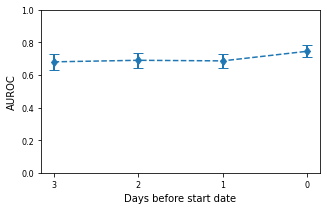

test_auroc_all_Test 0-7 days


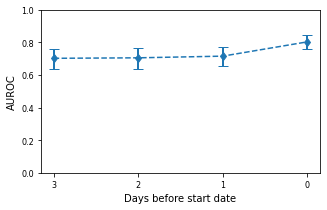

test_auroc_all_External test all


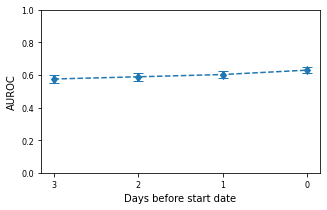

test_auroc_all_External test 0-7 days


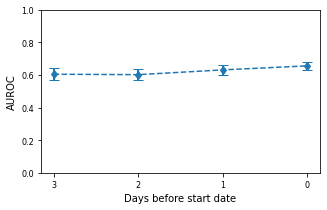

test_auroc_all
test_auroc_heart_Test all


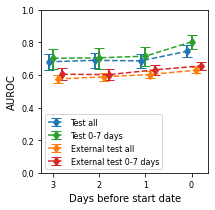

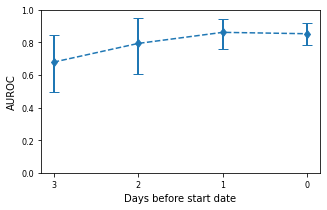

test_auroc_heart_Test 0-7 days


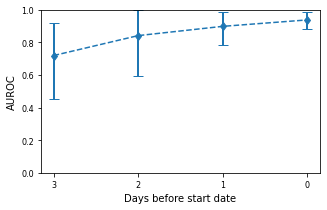

test_auroc_heart_External test all


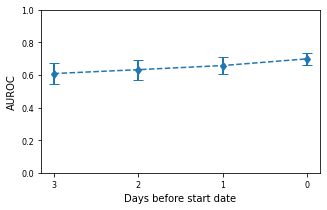

test_auroc_heart_External test 0-7 days


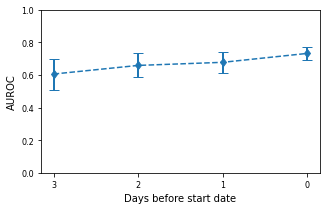

test_auroc_heart
test_auroc_liver_Test all


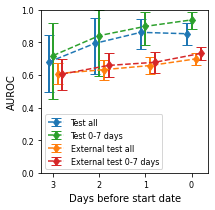

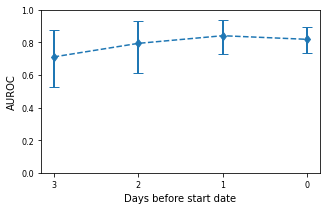

test_auroc_liver_Test 0-7 days


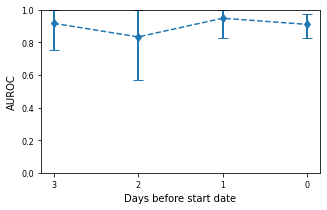

test_auroc_liver_External test all


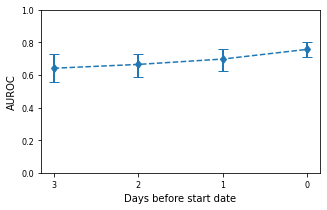

test_auroc_liver_External test 0-7 days


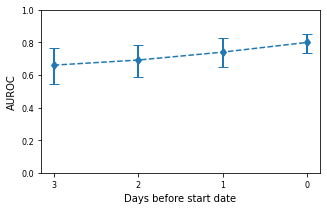

test_auroc_liver
test_auroc_infection_Test all


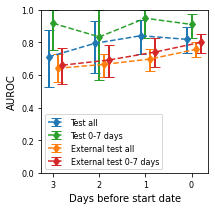

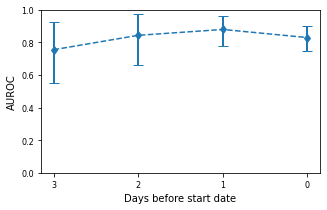

test_auroc_infection_Test 0-7 days


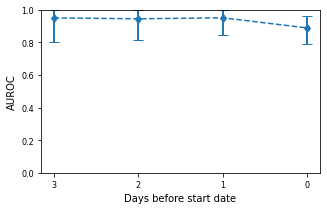

test_auroc_infection_External test all


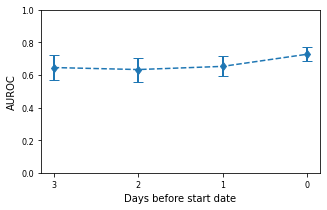

test_auroc_infection_External test 0-7 days


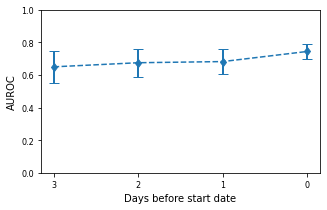

test_auroc_infection


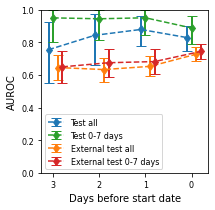

In [13]:
metric_names = args.metric_names
metric_names = ['auroc']


groups = ['Test all', 'Test 0-7 days', 'External test all', 'External test 0-7 days']
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']

metric_names = args.metric_names
metric_names = ['auroc']


plt_labels = [ "3", '2', "1", '0']
runs = [[#'c1e1215a95d140eda058a5bacc17a8e7',
        #'73ade10083c443b6978c3d2ce5d4a766',
        #'0d73855b2f8b40babc774cdc019ac3f5',
        '5bbd13f3ad3343f9800042cc4d271d74',
        'b2f35a3c973a4aee9b422edd31642c08',
        'ee2eeff4537c49ffb6a455b14aeec715',
        'f899fd8ea23f44c38e89c19a937b4111'],
        [#'5e67a99b15534b9e8f50da8b7e5eddbd',
        # 'b48f1bf080c7429b9c819b7fc33b6a57',
        # '4c990d3587f64321bf3167b9e9baf6b3',
        'c030454e79f04e618cb20debdbbc4fee',
        'b6321863269f40a69a57bd54022dff75',
        '4865ff3889bb471dabf5dcfbd1decd6a',
        '52d929585bd84345a5007ec99e1f3185',],
        [#'bdc911c822c4415bb54ce89a313d1a7e',
        # '449f163e30484aebb90007d924825f39',
        # '50a9e848d8fd4aa9a5570fd6907042b8',
        'c050ec741e624dbdac6ca292f6e08f77',
        '9515d0823f0b425f8e97881de5478f41',
        '54086b89dda9449e8b7d425fa6d13c28',
        '796fe8106bd24d69a7c282a068916742'],
        [#'e753c68e4ee74712a2e5a15017785c99',
        # 'df136a09085c47caa61cc5843cfedcab',
        # '035f987b9e114c92a5c8bc08a96cc6f2',
        '4a2a83cddb3b4826946fdbde73fa4790',
        '13b8a6ef83d946dd941db5835277f16e',
        'e96fdb411f444c7fb1eaf536aa3ec9ff',
        '5801be55809c4e3e91478d26ee0ee614',],
        # [#'59257af9f74d4717a1594ba2da17f35c',
        # '2efd1ec507f44e3d83cbcacef03e7147',
        # '0fcc2380c56745e8a60ab9b649bac676',
        # 'f49df2ce4f4d4081aa614dd63f037e82',
        # '53ca636a65134752bf9d955db639b609',
        # '6c8218631d1940a280d5df494406304a',
        # '5e3bca6c35e342b0b1945f216a90af90',],
        # [#'ca0a4bb8f7724d82a566e161e1542c5b',
        # '2c1c3138cdc0494b8e49b95764e63575',
        # '26e491b66f00425d85a75e88818265b5',
        # '205399c3b4a64ebdba056e56cf292a05',
        # 'd6c385dd87984da28842ff7acd5ffdc7',
        # 'acd3199f5fdc44d384af80cc6f7df62c',
        # '70c939cd7f6a4a96839fb18119bc3a2e',]
        ]


subgroups = ["", "_heart", "_liver", "_infection"]
subgroup_labels = ["all", "heart", "liver", "infection"]
plot_rolling_window(metric_names, subgroups, subgroup_labels, runs, plt_labels, groups, colors=colors)

# Clinical impact

Clinical impact_all_UCLA
Clinical impact_all_CEDARS
Clinical impact_heart_UCLA
Clinical impact_heart_CEDARS
Clinical impact_liver_UCLA
Clinical impact_liver_CEDARS
Clinical impact_infection_UCLA
Clinical impact_infection_CEDARS


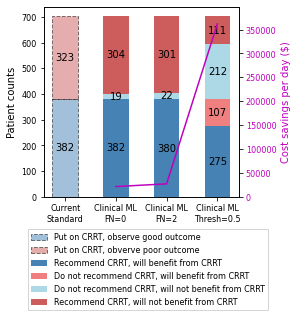

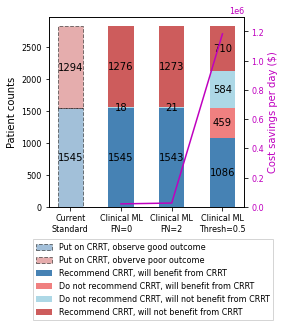

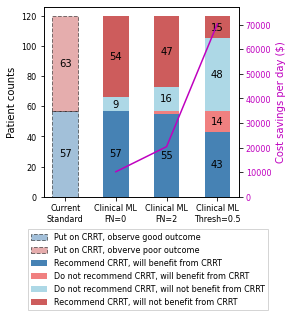

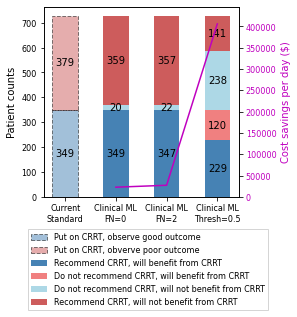

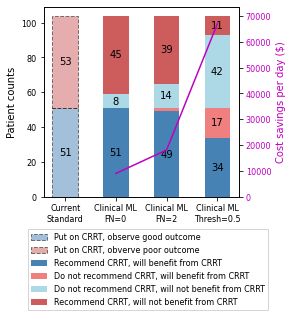

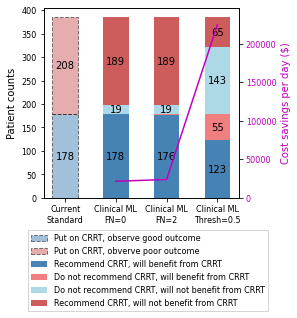

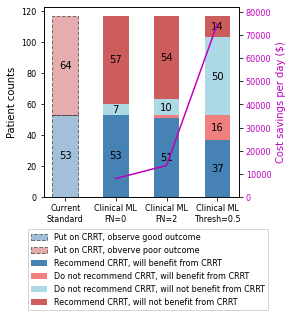

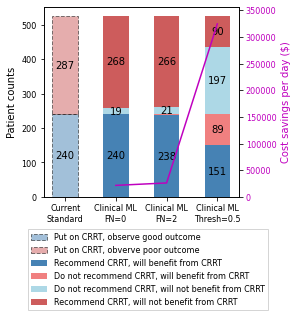

In [95]:
from models.static_models import METRIC_MAP
from sklearn.metrics import auc, det_curve, confusion_matrix


conf_matrix = ["TP", "FN", "TN","FP" ]
metric_fns = [METRIC_MAP[metric] for metric in conf_matrix]

plt_labels = ['UCLA', "CEDARS"]
runs = ['a07635aa0e50492d811d0ac7d9e807ac', '548afa05e3ee42208c20a2557dc1800a']
runs = ['125c0fb5c21f4533a45a9258822de83e', 'ce12b0e992014d30a3d0ee1d44610dc5']
subgroups = ["", "_heart", "_liver", "_infection"]
subgroup_labels = ["all", "heart", "liver", "infection"]

colors = ['steelblue','lightcoral','lightblue','indianred']
conf_matrix_label = ['Recommend CRRT, will benefit from CRRT','Do not recommend CRRT, will benefit from CRRT','Do not recommend CRRT, will not benefit from CRRT','Recommend CRRT, will not benefit from CRRT']
conf_matrix_baseline_label = ['Put on CRRT, observe good outcome','','','Put on CRRT, obverve poor outcome']

for i in range(len(subgroups)):

    for j in range(len(runs)):
        run = client.get_run(runs[j])
        
        modeln = run.data.tags['modeln']
        prefix = f"{modeln}_test{subgroups[i]}"

        metrics = run.data.metrics
        
        experiment_id = client.get_experiment_by_name("static_learning").experiment_id
        
        predict_probas = pickle.load(open(join(mlflow_path, experiment_id, run.info.run_id, "artifacts", "predict_probas", f"{prefix}__predict_probas.pkl"), 'rb'))
        labels = pickle.load(open(join(mlflow_path, experiment_id, run.info.run_id, "artifacts", "predict_probas", f"{prefix}__labels.pkl"), 'rb'))

        comparison = pd.merge(predict_probas.to_frame(),labels.to_frame(),how='inner', on=['IP_PATIENT_ID','Start Date', 'DATE'])
        y_true = comparison['recommend_crrt'].values
        y_pred = comparison[0].values

        grouping_labels = ['Current\nStandard', 'Clinical ML\nFN=0','Clinical ML\nFN=2','Clinical ML\nThresh=0.5']
        
        # Current clinical practice
        conf_matrix_values = {metric: [] for metric in conf_matrix}
        for metric_name, metric_fn in zip(conf_matrix,metric_fns):
            conf_matrix_values[metric_name].append(metric_fn(y_true, y_true, 0.5))
        conf_matrix_values['FP'] = conf_matrix_values['TN']
        conf_matrix_values['TN'] = [0]

        # Search for good threshold
        fpr, fnr, thresholds = det_curve(y_true, y_pred)
        use_thresh = []
        for threshold in thresholds:
            if confusion_matrix(y_true, (y_pred >= threshold).astype(int))[1, 0] == 0 \
                or confusion_matrix(y_true, (y_pred >= threshold).astype(int))[1, 0] == 2:
                use_thresh.append(threshold)
            if len(use_thresh) == len(grouping_labels)-2:
                break
        
        for k in range(1,len(grouping_labels)-1):
            for metric_name, metric_fn in zip(conf_matrix,metric_fns):
                conf_matrix_values[metric_name].append(metric_fn(y_true, y_pred, use_thresh[k-1]))

        # Current clinical practice
        for metric_name, metric_fn in zip(conf_matrix,metric_fns):
            conf_matrix_values[metric_name].append(metric_fn(y_true, y_pred, 0.5))
            
        fig, ax = plt.subplots()
        bottom = np.zeros(len(grouping_labels)-1)
        bottom_baseline = 0

        for k, metric_name in enumerate(conf_matrix):
            data = conf_matrix_values[metric_name]
            if data[0] > 0:
                p = ax.bar(grouping_labels[0], data[0], 0.5, label=conf_matrix_baseline_label[k], bottom=bottom_baseline, edgecolor='black',linestyle='--',color=colors[k], alpha=0.5)
                bottom_baseline += data[0]
                labels = [int(v) if v > 2 else "" for v in p.datavalues]    
                ax.bar_label(p, labels=labels, label_type="center")


        for k, metric_name in enumerate(conf_matrix):
            p = ax.bar(grouping_labels[1:], conf_matrix_values[metric_name][1:], 0.5, label=conf_matrix_label[k], bottom=bottom, color=colors[k])
            bottom += conf_matrix_values[metric_name][1:]

            labels = [int(v) if v > 2 else "" for v in p.datavalues]    
            ax.bar_label(p, labels=labels, label_type="center")

        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('Cost savings per day ($)', color='m')  # we already handled the x-label with ax1
        savings = np.array(conf_matrix_values['TN'][1:])+np.array(conf_matrix_values['FN'][1:])
        
        prices = [543, 3486/7, 2117/7, 276.70*1.06, 2607/7,3089/7,436*1.06, 3629.80, 1100, 3700]
        ax2.errorbar(grouping_labels, [None]+list(savings*np.mean(prices)), color='m')
        # ax2.errorbar(grouping_labels, [None]+list(savings*np.max(prices)), color='tab:green', linestyle='--')
        # ax2.errorbar(grouping_labels, [None]+list(savings*np.min(prices)), color='tab:green', linestyle='--')
        ax2.set_ylim([0, np.max(savings*np.mean(prices))+0.1*np.max(savings*np.mean(prices))])
        ax2.tick_params(axis='y', labelcolor='m')

        # ax.set_title(f"Clinical impact_{subgroup_labels[i]}_{plt_labels[j]}")
        print(f"Clinical impact_{subgroup_labels[i]}_{plt_labels[j]}")
        ax.legend(loc='upper left', bbox_to_anchor=(-0.1, -0.15),
          fancybox=False, shadow=False, ncol=1)

        ax.set_ylabel("Patient counts")
        fig = plt.gcf()
        fig.set_size_inches(3.5, 3.5)
        plt.savefig(f'./posthoc/Clinical impact_{subgroup_labels[i]}_{plt_labels[j]}.svg', format='svg',  bbox_inches="tight")


# Randomness

True    290
Name: Reject H0, dtype: int64
False    276
True      14
Name: Reject H0, dtype: int64
True    144
Name: Reject H0, dtype: int64
False    119
True      25
Name: Reject H0, dtype: int64


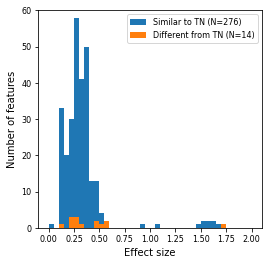

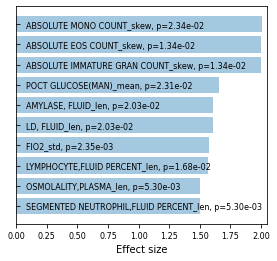

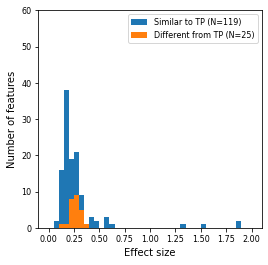

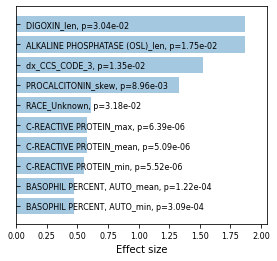

In [40]:
import pandas as pd
import os
os.makedirs('./posthoc', exist_ok=True)

df = pd.read_csv("C:/Users/jeffe/mlflow/mlruns/276694068661550192/57d4dbbe651b467d80bf2c097df76275/artifacts/xgb_test__dist_comparison_table.csv")

df_fntp = df[df['Unnamed: 0']=='fn_vs_tp']
df_fntp_true = df_fntp[df_fntp['Reject H0']==True]
df_fntp_true_var = df_fntp_true['Unnamed: 1']
print(df_fntp_true['Reject H0'].value_counts())

df_fntn = df[df['Unnamed: 0']=='fn_vs_tn']
df_fntn_shared = df_fntn[df_fntn['Unnamed: 1'].isin(df_fntp_true_var)]
print(df_fntn_shared['Reject H0'].value_counts())
df_fntn_shared_false = df_fntn_shared[df_fntn_shared['Reject H0']==False]['Unnamed: 1']
df_fntn_shared_true = df_fntn_shared[df_fntn_shared['Reject H0']==True]['Unnamed: 1']

plt.figure(figsize=(4,4))
plt.hist(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_false)]['Effect Size'], bins=40, range=(0,2), 
        label=f"Similar to TN (N={len(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_false)]['Effect Size'])})")
plt.hist(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_true)]['Effect Size'], bins=40, range=(0,2),
         label=f"Different from TN (N={len(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_true)]['Effect Size'])})")
plt.xlabel('Effect size')
plt.ylabel('Number of features')
plt.ylim([0,60])
plt.legend()
plt.savefig('./posthoc/randomness_fn.svg', format='svg',  bbox_inches="tight")

plt.figure(figsize=(4.5,4))
relevant = df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_false)].sort_values('Effect Size')
x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['Significance'][-10:])]
p = plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4)
plt.yticks(ha='left')
plt.tick_params(axis="y",direction="in", pad=-10)
plt.xlabel('Effect size')
plt.xlim([0,2.05])
plt.savefig('./posthoc/randomness_fn_feat.svg', format='svg',  bbox_inches="tight")


df_fptn = df[df['Unnamed: 0']=='fp_vs_tn']
df_fptn_true = df_fptn[df_fptn['Reject H0']==True]
df_fptn_true_var = df_fptn_true['Unnamed: 1']
print(df_fptn_true['Reject H0'].value_counts())

df_fptp = df[df['Unnamed: 0']=='fp_vs_tp']
df_fptp_shared = df_fptp[df_fptp['Unnamed: 1'].isin(df_fptn_true_var)]
print(df_fptp_shared['Reject H0'].value_counts())
df_fptp_shared_false = df_fptp_shared[df_fptp_shared['Reject H0']==False]['Unnamed: 1']
df_fptp_shared_true = df_fptp_shared[df_fptp_shared['Reject H0']==True]['Unnamed: 1']

plt.figure(figsize=(4,4))
plt.hist(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_false)]['Effect Size'], bins=40, range=(0,2),
         label=f"Similar to TP (N={len(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_false)]['Effect Size'])})")
plt.hist(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_true)]['Effect Size'], bins=40, range=(0,2),
         label=f"Different from TP (N={len(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_true)]['Effect Size'])})")
plt.xlabel('Effect size')
plt.ylabel('Number of features')
plt.ylim([0,60])
plt.legend()
plt.savefig('./posthoc/randomness_fp.svg', format='svg',  bbox_inches="tight")

plt.figure(figsize=(4.5,4))
relevant = df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_false)].sort_values('Effect Size')
x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['Significance'][-10:])]
plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4)
plt.yticks(ha='left')
plt.tick_params(axis="y",direction="in", pad=-10)
plt.xlabel('Effect size')
plt.xlim([0,2.05])
plt.savefig('./posthoc/randomness_fp_feat.svg', format='svg',  bbox_inches="tight")


# Tabulate results

In [42]:
def get_table(id):
    table = {}

    run = client.get_run(id)
    metrics = run.data.metrics
    modeln = run.data.tags['modeln']

    for metric_name in ["accuracy", "ap", "auroc", "brier", "precision", "recall"]:
        table[metric_name] = {}
        for subgroup in ["", "_heart", "_liver", "_infection","_no_heart_liver_infection"]:
            prefix = f"{modeln}_test{subgroup}"
            subgroup = "all" if subgroup == "" else subgroup

            if f"{prefix}__{metric_name}_CI_low" in metrics:
                ci_low = metrics[f"{prefix}__{metric_name}_CI_low"]
                ci_high = metrics[f"{prefix}__{metric_name}_CI_high"]
                metric = metrics[f"{prefix}__{metric_name}"]
                table[metric_name][subgroup.replace("_","")] = f"{metric:.2f} ({ci_low:.2f}-{ci_high:.2f})"
            else:
                table[metric_name][subgroup.replace("_","")] = metrics[f"{prefix}__{metric_name}"]
    
    return table

## Output from mlflow without CI

In [76]:
# The id of the test run from mlflow
ucla_cedars_run_id = "11a8d9fe093b4e4b82f498f96c66bc7f"
ucla_ucla_run_id = "92cfb3bbeddb465ca4c0c6c4ca5efadd"
cedars_cedars_run_id = "513e5a5453a84031ba446b2c3d52578b"
cedars_ucla_run_id = "6d13ec12e43a49789e278b0bec687d7e"
both_id = "c4511a2c69ca47168063487a82b0c9c2"

table = get_table(ucla_ucla_run_id)
print('UCLA to UCLA')
display(pd.DataFrame(table))

table = get_table(ucla_cedars_run_id)
print('UCLA to CEDARS')
display(pd.DataFrame(table))

table = get_table(cedars_ucla_run_id)
print('CEDARS to UCLA')
display(pd.DataFrame(table))

table = get_table(cedars_cedars_run_id)
print('CEDARS to CEDARS')
display(pd.DataFrame(table))

table = get_table(both_id)
print('UCLA+CEDARS to UCLA+CEDARS')
display(pd.DataFrame(table))

UCLA to UCLA


,accuracy,ap,auroc,brier,precision,recall
all,0.690780,0.766134,0.745271,0.214515,0.712435,0.719895
heart,0.758333,0.847251,0.852687,0.161153,0.741379,0.754386
liver,0.730769,0.822957,0.818350,0.181821,0.755556,0.666667
infection,0.743590,0.821866,0.829304,0.173097,0.725490,0.698113


UCLA to CEDARS


,accuracy,ap,auroc,brier,precision,recall
all,0.588235,0.657867,0.629476,0.238136,0.604677,0.702913
heart,0.641484,0.670856,0.698876,0.223221,0.618919,0.656160
liver,0.689119,0.717551,0.757049,0.201201,0.654255,0.691011
infection,0.660342,0.681354,0.727120,0.212547,0.626556,0.629167


CEDARS to UCLA


,accuracy,ap,auroc,brier,precision,recall
all,0.590755,0.593822,0.575363,0.246373,0.579960,0.892523
heart,0.734214,0.833633,0.815443,0.195023,0.758621,0.731302
liver,0.716878,0.786756,0.785461,0.201506,0.724252,0.749141
infection,0.727829,0.824583,0.811199,0.196972,0.750000,0.700599


CEDARS to CEDARS


,accuracy,ap,auroc,brier,precision,recall
all,0.617958,0.669085,0.669762,0.227698,0.633136,0.697068
heart,0.648276,0.629048,0.716923,0.215229,0.620690,0.553846
liver,0.733333,0.725620,0.813953,0.177254,0.730769,0.593750
infection,0.695238,0.701084,0.769692,0.190478,0.641026,0.581395


UCLA+CEDARS to UCLA+CEDARS


,accuracy,ap,auroc,brier,precision,recall
all,0.636421,0.724643,0.686858,0.222113,0.635911,0.797504
heart,0.675532,0.773196,0.770838,0.202325,0.640669,0.809859
liver,0.703608,0.801493,0.798251,0.192953,0.669355,0.834171
infection,0.706977,0.773360,0.793358,0.194706,0.661157,0.784314


## Output from mlflow after post-hoc with CI

In [77]:
# The id of the post-hoc test run from mlflow with CI
ucla_cedars_run_id = "ce12b0e992014d30a3d0ee1d44610dc5"
ucla_ucla_run_id = "125c0fb5c21f4533a45a9258822de83e"
cedars_cedars_run_id = "548afa05e3ee42208c20a2557dc1800a"
cedars_ucla_run_id = "a07635aa0e50492d811d0ac7d9e807ac"
both_id = "7bbdb269ea9041f799fa9de7e7d34b45"

table = get_table(ucla_ucla_run_id)
print('UCLA to UCLA')
display(pd.DataFrame(table))

table = get_table(ucla_cedars_run_id)
print('UCLA to CEDARS')
display(pd.DataFrame(table))

table = get_table(cedars_ucla_run_id)
print('CEDARS to UCLA')
display(pd.DataFrame(table))

table = get_table(cedars_cedars_run_id)
print('CEDARS to CEDARS')
display(pd.DataFrame(table))

table = get_table(both_id)
print('UCLA+CEDARS to UCLA+CEDARS')
display(pd.DataFrame(table))

UCLA to UCLA


,accuracy,ap,auroc,brier,precision,recall
all,0.69 (0.66-0.72),0.77 (0.72-0.81),0.75 (0.71-0.78),0.21 (0.19-0.23),0.71 (0.67-0.76),0.72 (0.68-0.77)
heart,0.76 (0.68-0.83),0.85 (0.76-0.92),0.85 (0.78-0.92),0.16 (0.12-0.21),0.74 (0.63-0.85),0.75 (0.64-0.86)
liver,0.73 (0.64-0.82),0.82 (0.73-0.90),0.82 (0.74-0.90),0.18 (0.13-0.23),0.76 (0.62-0.88),0.67 (0.54-0.79)
infection,0.74 (0.67-0.82),0.82 (0.73-0.90),0.83 (0.74-0.90),0.17 (0.13-0.22),0.73 (0.60-0.85),0.70 (0.57-0.82)


UCLA to CEDARS


,accuracy,ap,auroc,brier,precision,recall
all,0.59 (0.57-0.61),0.66 (0.63-0.69),0.63 (0.61-0.65),0.24 (0.23-0.24),0.60 (0.58-0.63),0.70 (0.68-0.73)
heart,0.64 (0.61-0.68),0.67 (0.62-0.72),0.70 (0.66-0.74),0.22 (0.21-0.24),0.62 (0.57-0.67),0.66 (0.60-0.70)
liver,0.69 (0.64-0.74),0.72 (0.64-0.79),0.76 (0.71-0.80),0.20 (0.18-0.22),0.65 (0.58-0.73),0.69 (0.62-0.76)
infection,0.66 (0.62-0.70),0.68 (0.62-0.75),0.73 (0.69-0.77),0.21 (0.19-0.23),0.63 (0.57-0.69),0.63 (0.57-0.69)


CEDARS to UCLA


,accuracy,ap,auroc,brier,precision,recall
all,0.59 (0.57-0.61),0.59 (0.57-0.62),0.58 (0.56-0.60),0.25 (0.24-0.25),0.58 (0.56-0.60),0.89 (0.88-0.91)
heart,0.73 (0.70-0.76),0.83 (0.80-0.87),0.82 (0.78-0.85),0.20 (0.19-0.20),0.76 (0.71-0.80),0.73 (0.69-0.78)
liver,0.72 (0.68-0.75),0.79 (0.74-0.84),0.79 (0.75-0.82),0.20 (0.19-0.21),0.72 (0.67-0.77),0.75 (0.70-0.80)
infection,0.73 (0.69-0.76),0.82 (0.78-0.86),0.81 (0.78-0.84),0.20 (0.19-0.20),0.75 (0.70-0.80),0.70 (0.65-0.75)


CEDARS to CEDARS


,accuracy,ap,auroc,brier,precision,recall
all,0.62 (0.58-0.66),0.67 (0.61-0.73),0.67 (0.63-0.72),0.23 (0.21-0.24),0.63 (0.59-0.68),0.70 (0.65-0.75)
heart,0.65 (0.57-0.73),0.63 (0.52-0.77),0.72 (0.63-0.80),0.22 (0.18-0.25),0.62 (0.49-0.74),0.55 (0.42-0.68)
liver,0.73 (0.63-0.83),0.73 (0.57-0.90),0.81 (0.71-0.91),0.18 (0.13-0.22),0.73 (0.55-0.90),0.59 (0.45-0.76)
infection,0.70 (0.61-0.78),0.70 (0.57-0.84),0.77 (0.68-0.85),0.19 (0.16-0.23),0.64 (0.49-0.79),0.58 (0.44-0.73)


UCLA+CEDARS to UCLA+CEDARS


,accuracy,ap,auroc,brier,precision,recall
all,0.64 (0.62-0.65),0.72 (0.70-0.75),0.69 (0.67-0.71),0.22 (0.22-0.23),0.64 (0.62-0.66),0.80 (0.78-0.82)
heart,0.68 (0.64-0.71),0.77 (0.72-0.82),0.77 (0.73-0.81),0.20 (0.19-0.21),0.64 (0.59-0.69),0.81 (0.76-0.85)
liver,0.70 (0.66-0.75),0.80 (0.74-0.86),0.80 (0.75-0.84),0.19 (0.18-0.21),0.67 (0.61-0.73),0.83 (0.78-0.89)
infection,0.71 (0.66-0.75),0.77 (0.71-0.83),0.79 (0.75-0.83),0.19 (0.18-0.21),0.66 (0.60-0.73),0.78 (0.73-0.84)


## Output from mlflow after post-hoc with CI, and limit 7 days

In [100]:
# The id of the post-hoc test run from mlflow with CI with limiting 7 days on CRRT
ucla_cedars_run_id = "5801be55809c4e3e91478d26ee0ee614"
ucla_ucla_run_id = "52d929585bd84345a5007ec99e1f3185"
cedars_cedars_run_id = "cf50989ed9e24cf3aefd4b6232c40ff5"
cedars_ucla_run_id = "b985f4b14d9e42da85dc296ce9e64118"
both_id = "e7538934abdf4977af24b114fcac83d9"

table = get_table(ucla_ucla_run_id)
print('UCLA to UCLA')
display(pd.DataFrame(table))

table = get_table(ucla_cedars_run_id)
print('UCLA to CEDARS')
display(pd.DataFrame(table))

table = get_table(cedars_ucla_run_id)
print('CEDARS to UCLA')
display(pd.DataFrame(table))

table = get_table(cedars_cedars_run_id)
print('CEDARS to CEDARS')
display(pd.DataFrame(table))

table = get_table(both_id)
print('UCLA+CEDARS to UCLA+CEDARS')
display(pd.DataFrame(table))

UCLA to UCLA


,accuracy,ap,auroc,brier,precision,recall
all,0.74 (0.70-0.79),0.81 (0.76-0.86),0.80 (0.76-0.85),0.18 (0.16-0.21),0.75 (0.69-0.81),0.75 (0.68-0.80)
heart,0.84 (0.75-0.92),0.94 (0.87-0.98),0.94 (0.88-0.98),0.10 (0.06-0.15),0.85 (0.71-0.97),0.81 (0.67-0.93)
liver,0.80 (0.68-0.88),0.91 (0.82-0.98),0.91 (0.83-0.97),0.13 (0.08-0.19),0.87 (0.71-1.00),0.69 (0.52-0.85)
infection,0.81 (0.71-0.90),0.89 (0.79-0.96),0.89 (0.79-0.96),0.13 (0.08-0.19),0.81 (0.65-0.95),0.71 (0.54-0.87)


UCLA to CEDARS


,accuracy,ap,auroc,brier,precision,recall
all,0.60 (0.57-0.62),0.67 (0.63-0.70),0.66 (0.63-0.68),0.23 (0.23-0.24),0.59 (0.56-0.62),0.71 (0.68-0.75)
heart,0.66 (0.62-0.70),0.70 (0.63-0.76),0.73 (0.69-0.77),0.21 (0.19-0.23),0.63 (0.57-0.69),0.67 (0.61-0.73)
liver,0.72 (0.66-0.78),0.76 (0.67-0.84),0.80 (0.74-0.85),0.18 (0.16-0.21),0.68 (0.59-0.76),0.71 (0.62-0.79)
infection,0.67 (0.62-0.72),0.68 (0.60-0.75),0.74 (0.70-0.79),0.20 (0.18-0.22),0.61 (0.54-0.68),0.63 (0.55-0.70)


CEDARS to UCLA


,accuracy,ap,auroc,brier,precision,recall
all,0.59 (0.57-0.61),0.59 (0.56-0.62),0.60 (0.58-0.63),0.24 (0.24-0.25),0.57 (0.55-0.59),0.87 (0.85-0.89)
heart,0.75 (0.72-0.79),0.84 (0.80-0.89),0.84 (0.81-0.88),0.19 (0.18-0.20),0.78 (0.72-0.84),0.71 (0.65-0.77)
liver,0.74 (0.69-0.79),0.81 (0.74-0.87),0.82 (0.77-0.86),0.19 (0.18-0.21),0.76 (0.69-0.82),0.72 (0.64-0.79)
infection,0.75 (0.71-0.79),0.83 (0.79-0.88),0.83 (0.79-0.87),0.19 (0.18-0.20),0.77 (0.72-0.84),0.68 (0.61-0.74)


CEDARS to CEDARS


,accuracy,ap,auroc,brier,precision,recall
all,0.60 (0.55-0.65),0.66 (0.58-0.74),0.67 (0.61-0.72),0.23 (0.21-0.25),0.60 (0.53-0.66),0.64 (0.57-0.71)
heart,0.67 (0.58-0.75),0.71 (0.57-0.83),0.73 (0.62-0.83),0.21 (0.17-0.25),0.65 (0.50-0.81),0.55 (0.40-0.70)
liver,0.72 (0.60-0.84),0.72 (0.52-0.89),0.79 (0.64-0.90),0.18 (0.14-0.24),0.69 (0.44-0.90),0.55 (0.31-0.75)
infection,0.71 (0.61-0.82),0.72 (0.54-0.85),0.75 (0.62-0.86),0.19 (0.15-0.24),0.67 (0.44-0.85),0.53 (0.35-0.71)


UCLA+CEDARS to UCLA+CEDARS


,accuracy,ap,auroc,brier,precision,recall
all,0.63 (0.61-0.65),0.74 (0.71-0.76),0.71 (0.69-0.73),0.22 (0.21-0.22),0.61 (0.58-0.64),0.77 (0.75-0.80)
heart,0.69 (0.64-0.74),0.79 (0.73-0.85),0.80 (0.75-0.84),0.19 (0.18-0.21),0.64 (0.57-0.70),0.82 (0.76-0.87)
liver,0.72 (0.66-0.78),0.80 (0.71-0.87),0.82 (0.76-0.87),0.19 (0.17-0.21),0.67 (0.59-0.75),0.83 (0.76-0.90)
infection,0.72 (0.68-0.78),0.79 (0.72-0.86),0.82 (0.77-0.87),0.19 (0.17-0.20),0.65 (0.58-0.72),0.78 (0.70-0.85)
